# Model Building

This Jupyter Notebook will build different electric demand forecasting models and compare them.

## 1. Loading Data and Libraries

In [1]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline
sns.set()

In [2]:
# Importing the dataset
df = pd.read_csv('./Data/cleandata/CleanedCT.csv', parse_dates=['ts'], index_col='ts')
df = df.drop(['Unnamed: 0'], axis=1)
df['non_working'] = df.apply(lambda x: True if \
                                         ((x['non_working'] == 'non-working'))
                                         else False, axis = 1)
print('Data Frame Shape:', df.shape)
df.head()

Data Frame Shape: (113976, 14)


zone  demand  drybulb  dewpnt        date  year  month  \
ts                                                                           
2004-01-01 00:00:00   CT  3126.0     33.0    26.0  2004-01-01  2004      1   
2004-01-01 01:00:00   CT  2945.0     34.0    26.0  2004-01-01  2004      1   
2004-01-01 02:00:00   CT  2804.0     40.0    26.0  2004-01-01  2004      1   
2004-01-01 03:00:00   CT  2729.0     38.0    23.0  2004-01-01  2004      1   
2004-01-01 04:00:00   CT  2722.0     37.0    21.0  2004-01-01  2004      1   

                     hour day_of_week  day_of_year  weekend  holiday   trend  \
ts                                                                             
2004-01-01 00:00:00     0         Thu            1    False     True  7344.0   
2004-01-01 01:00:00     1         Thu            1    False     True  7345.0   
2004-01-01 02:00:00     2         Thu            1    False     True  7346.0   
2004-01-01 03:00:00     3         Thu            1    False     True  7347.0   
2004-01-01 04:00:00     4         Thu            1    False     True  7348.0   

                     non_working  
ts                                
2004-01-01 00:00:00         True  
2004-01-01 01:00:00         True  
2004-01-01 02:00:00         True  
2004-01-01 03:00:00         True  
2004-01-01 04:00:00         True

In [3]:
df['day_of_week'] = df['day_of_week'].astype('category')
df['non_working'] = df['non_working'].astype('category')
df['hour'] = df['hour'].astype('category')
df['month'] = df['month'].astype('category')

## 2. Defining Basic Functions

In [4]:
# Creating an empty dict to save all the erros from different models
dict_error = dict()

In [5]:
# creating function for plotting predicted vs actual energy values
def PredTrueReg(pred, truth, model_name=None):
    """
    Plots the observed energy consumption against the predicted energy consumption
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.scatter(truth, pred, alpha=0.7) 
    plt.xlabel("Observed Electric Consumption (MwH)")
    plt.ylabel("Predicted Electric Consumption (MwH)")
    plt.title(f"Observed VS Predicted Electric Consumption using {model_name}", fontsize=14)

    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color='black')

In [6]:
def error_metrics(y_pred, y_observed, model_name = None, test = True):

    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()

    if isinstance(y_observed, np.ndarray):
        y_observed = y_observed
    else:
        y_observed = y_observed.to_numpy()

    print(f'Error metrics for {model_name} \n')

    RMSE = np.sqrt(mean_squared_error(y_observed, y_pred))
    print(f'Root Mean Squared Error (RMSE): {round(RMSE, 3)}')

    MAE = mean_absolute_error(y_observed, y_pred)
    print(f'Mean Absolute Error (MAE): {round(MAE, 3)}')

    MAPE = (np.mean(np.abs((y_observed - y_pred) / y_observed)) * 100)
    print(f'Mean Absolute Percentage Error (MAPE): {round(MAPE, 3)} %')

    R2 = r2_score(y_observed, y_pred)
    print(f'Variance Score (R2): {round(R2, 3)}')

    if test:
        train_test = 'test'
    else:
        train_test = 'train'

    names = ['model', 'train_test', 'RMSE', 'MAE', 'MAPE', 'R2']
    values = [model_name, train_test, RMSE, MAE, MAPE, R2]
    list_error = list(zip(names, values))

    for error in list_error:
        if error[0] in dict_error:
            dict_error[error[0]].append(error[1])
        else:
            dict_error[error[0]] = [error[1]]

In [7]:
def PlotTS(ts, title = None, alpha = 1):
 
    plt.figure(figsize=(16, 9))
    sns.lineplot(x=ts.index, y=np.array(ts.values), color='darkred', alpha = alpha)
    plt.title(str(title))
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MwH)')

    plt.show()

In [8]:
def PlotPredictedTS(observed_ts, predicted_ts, model_name=None, observed_alpha = 0.5, predicted_alpha = 0.7):
    
    plt.figure(figsize=(16, 9))
    sns.lineplot(x= observed_ts.index, y=np.array(observed_ts.values), color='red', alpha=observed_alpha, label='Observed')
    sns.lineplot(x= observed_ts.index, y=predicted_ts, color='lightslategrey', alpha=predicted_alpha, label='Predicted')
    plt.title(f'Observed VS Predicted Energy Consumption using {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MwH)')

    plt.show()

In [9]:
def TrainTestSplit(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):

    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('demand', axis = 1).iloc[:test_index]
    y_train = df.demand.iloc[:test_index]
    X_test = df.drop('demand', axis = 1).iloc[test_index:]
    y_test = df.demand.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

## 3. Linear Regression Models

### 3.1 SkLearn Linear Regression

In [10]:
df.head()

zone  demand  drybulb  dewpnt        date  year month  \
ts                                                                          
2004-01-01 00:00:00   CT  3126.0     33.0    26.0  2004-01-01  2004     1   
2004-01-01 01:00:00   CT  2945.0     34.0    26.0  2004-01-01  2004     1   
2004-01-01 02:00:00   CT  2804.0     40.0    26.0  2004-01-01  2004     1   
2004-01-01 03:00:00   CT  2729.0     38.0    23.0  2004-01-01  2004     1   
2004-01-01 04:00:00   CT  2722.0     37.0    21.0  2004-01-01  2004     1   

                    hour day_of_week  day_of_year  weekend  holiday   trend  \
ts                                                                            
2004-01-01 00:00:00    0         Thu            1    False     True  7344.0   
2004-01-01 01:00:00    1         Thu            1    False     True  7345.0   
2004-01-01 02:00:00    2         Thu            1    False     True  7346.0   
2004-01-01 03:00:00    3         Thu            1    False     True  7347.0   
2004-01-01 04:00:00    4         Thu            1    False     True  7348.0   

                    non_working  
ts                               
2004-01-01 00:00:00        True  
2004-01-01 01:00:00        True  
2004-01-01 02:00:00        True  
2004-01-01 03:00:00        True  
2004-01-01 04:00:00        True

In [11]:
dfsub = df.drop(['date', 'trend', 'day_of_week', 'day_of_year', 'zone', 'weekend', 'holiday'], axis=1)
dfsub.head()

demand  drybulb  dewpnt  year month hour non_working
ts                                                                       
2004-01-01 00:00:00  3126.0     33.0    26.0  2004     1    0        True
2004-01-01 01:00:00  2945.0     34.0    26.0  2004     1    1        True
2004-01-01 02:00:00  2804.0     40.0    26.0  2004     1    2        True
2004-01-01 03:00:00  2729.0     38.0    23.0  2004     1    3        True
2004-01-01 04:00:00  2722.0     37.0    21.0  2004     1    4        True

In [12]:
# Preparing dummy columns for use in sklearn's linear regression 
CT_lin = pd.get_dummies(dfsub, drop_first = True)
CT_lin.head()

demand  drybulb  dewpnt  year  month_2  month_3  month_4  \
ts                                                                              
2004-01-01 00:00:00  3126.0     33.0    26.0  2004        0        0        0   
2004-01-01 01:00:00  2945.0     34.0    26.0  2004        0        0        0   
2004-01-01 02:00:00  2804.0     40.0    26.0  2004        0        0        0   
2004-01-01 03:00:00  2729.0     38.0    23.0  2004        0        0        0   
2004-01-01 04:00:00  2722.0     37.0    21.0  2004        0        0        0   

                     month_5  month_6  month_7  ...  hour_15  hour_16  \
ts                                              ...                     
2004-01-01 00:00:00        0        0        0  ...        0        0   
2004-01-01 01:00:00        0        0        0  ...        0        0   
2004-01-01 02:00:00        0        0        0  ...        0        0   
2004-01-01 03:00:00        0        0        0  ...        0        0   
2004-01-01 04:00:00        0        0        0  ...        0        0   

                     hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
ts                                                                          
2004-01-01 00:00:00        0        0        0        0        0        0   
2004-01-01 01:00:00        0        0        0        0        0        0   
2004-01-01 02:00:00        0        0        0        0        0        0   
2004-01-01 03:00:00        0        0        0        0        0        0   
2004-01-01 04:00:00        0        0        0        0        0        0   

                     hour_23  non_working_True  
ts                                              
2004-01-01 00:00:00        0                 1  
2004-01-01 01:00:00        0                 1  
2004-01-01 02:00:00        0                 1  
2004-01-01 03:00:00        0                 1  
2004-01-01 04:00:00        0                 1  

[5 rows x 39 columns]

In [13]:
X_train, X_test, y_train, y_test = TrainTestSplit(CT_lin, test_size = 0.15, scale = True, cols_to_transform=['drybulb', 'dewpnt', 'year'])

lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

LinearRegression()

Text(0.5, 0, 'Features Used')

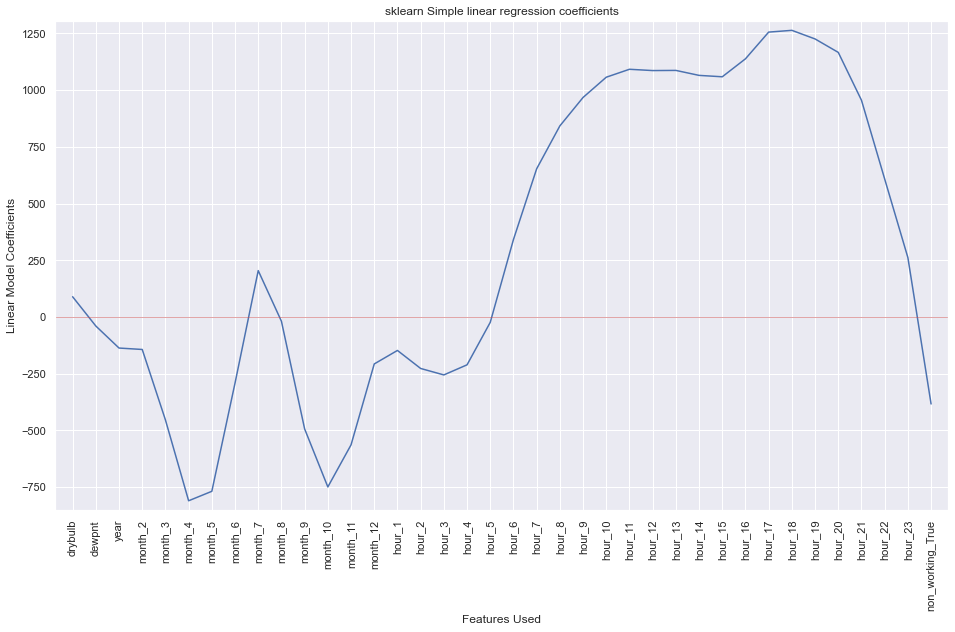

In [14]:
# Plotting the coefficients to check the importance of each coefficient 

# Plot the coefficients
plt.figure(figsize=(16, 9))
plt.plot(range(len(X_train.columns)), lm.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('sklearn Simple linear regression coefficients')
plt.ylabel('Linear Model Coefficients')
plt.xlabel('Features Used')

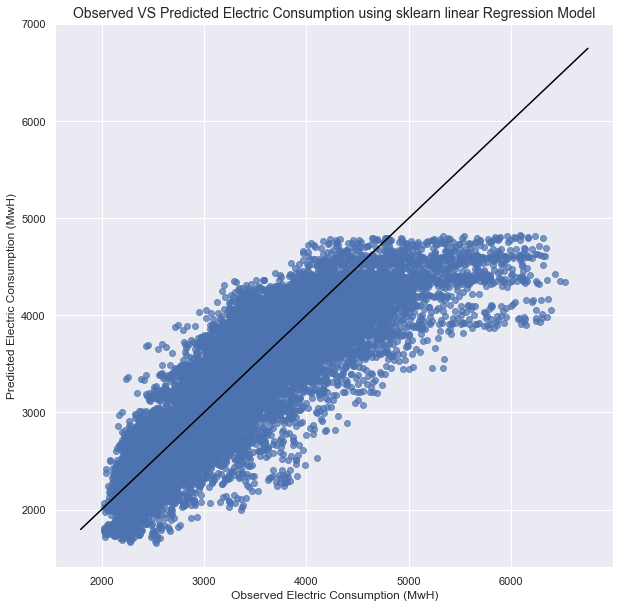

In [15]:
# Plotting lm.predict(X) vs observed energy consumption

PredTrueReg(lm.predict(X_test), y_test, model_name = 'sklearn linear Regression Model')

In [16]:
error_metrics(lm.predict(X_train), y_train, model_name = 'sklearn linear Regression Model with Scaling', test = False)

Error metrics for sklearn linear Regression Model with Scaling 

Root Mean Squared Error (RMSE): 404.919
Mean Absolute Error (MAE): 299.61
Mean Absolute Percentage Error (MAPE): 8.143 %
Variance Score (R2): 0.74


In [17]:
# on test set
error_metrics(lm.predict(X_test), y_test, model_name = 'sklearn linear Regression Model with Scaling', test = True)

Error metrics for sklearn linear Regression Model with Scaling 

Root Mean Squared Error (RMSE): 442.891
Mean Absolute Error (MAE): 331.248
Mean Absolute Percentage Error (MAPE): 9.382 %
Variance Score (R2): 0.673


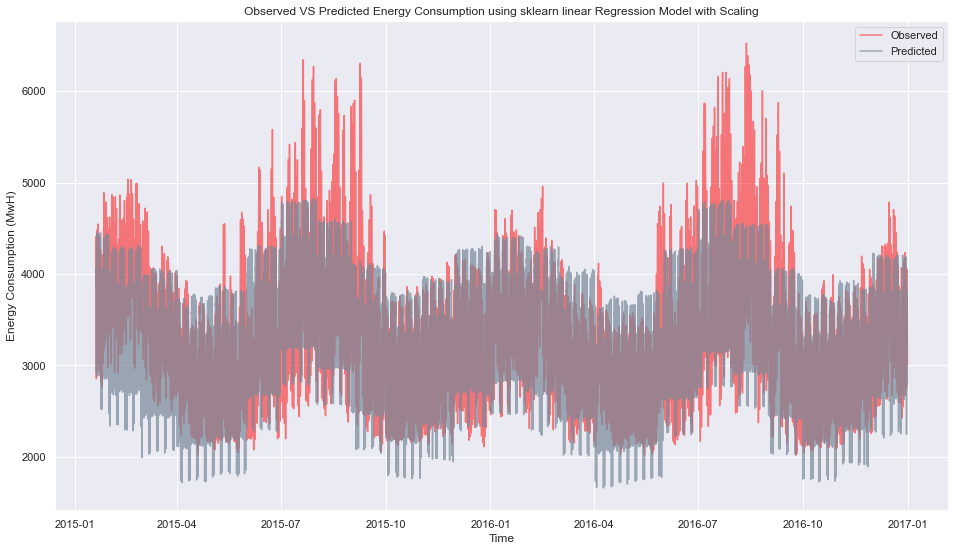

In [18]:
# Plotting the predicted values with the original time series (test set)
PlotPredictedTS(y_test, lm.predict(X_test), model_name='sklearn linear Regression Model with Scaling')

### 3.1.1 Baseline Forecast

In [19]:
# Baseline Persistent Forecast (One Year Before)
error_metrics(CT_lin.loc[X_test.index.shift(-8760, freq='h'), 'demand'], y_test, model_name='Baseline Persistent Forecast (One Year Before)', test=True)

Error metrics for Baseline Persistent Forecast (One Year Before) 

Root Mean Squared Error (RMSE): 513.197
Mean Absolute Error (MAE): 379.745
Mean Absolute Percentage Error (MAPE): 10.765 %
Variance Score (R2): 0.561


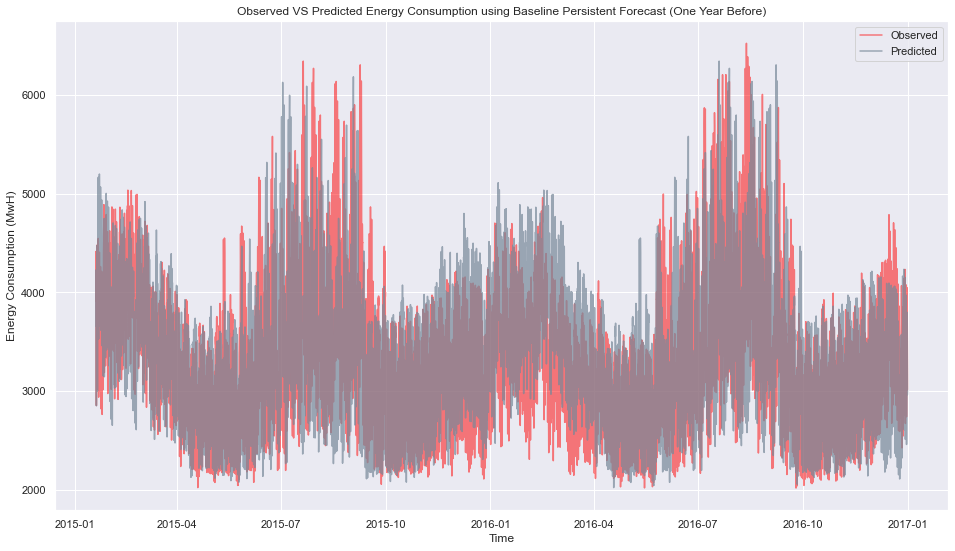

In [20]:
PlotPredictedTS(y_test, CT_lin.loc[X_test.index.shift(-8760, freq='h'), 'demand'].to_numpy(), model_name='Baseline Persistent Forecast (One Year Before)')

In [21]:
# Baseline Persistent Forecast (One Hour Before)
error_metrics(CT_lin.loc[X_test.index.shift(-1, freq='h'), 'demand'], y_test, model_name='Baseline Persistent Forecast (One Hour Before)', test=True)

Error metrics for Baseline Persistent Forecast (One Hour Before) 

Root Mean Squared Error (RMSE): 184.311
Mean Absolute Error (MAE): 141.312
Mean Absolute Percentage Error (MAPE): 4.232 %
Variance Score (R2): 0.943


In [22]:
# Baseline Persistent Forecast (One Week Before)
error_metrics(CT_lin.loc[X_test.index.shift(-168, freq='h'), 'demand'], y_test, model_name='Baseline Persistent Forecast (One Week Before)', test=True)

Error metrics for Baseline Persistent Forecast (One Week Before) 

Root Mean Squared Error (RMSE): 465.045
Mean Absolute Error (MAE): 328.765
Mean Absolute Percentage Error (MAPE): 9.222 %
Variance Score (R2): 0.64


## 3.2 Ridge Regression

/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Features Used')

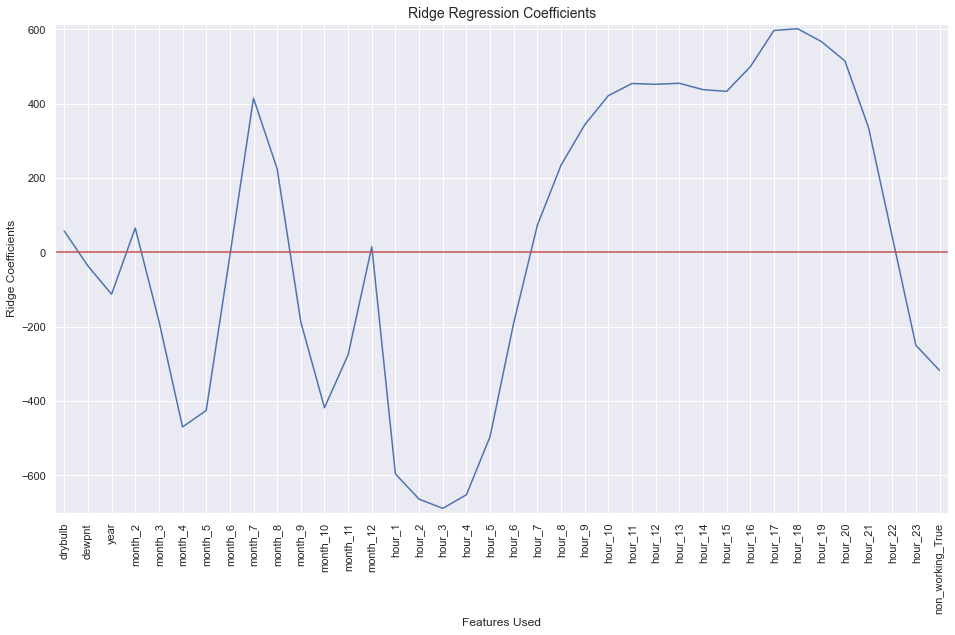

In [23]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.2, normalize=True)

ridge.fit(X_train, y_train)

plt.figure(figsize=(16,9))
sns.lineplot(range(len(X_train.columns)), ridge.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.01)
plt.axhline(0, color='r')
plt.title('Ridge Regression Coefficients', fontsize=14)
plt.ylabel('Ridge Coefficients')
plt.xlabel('Features Used')


Text(0.5, 0, 'Ridge Predicted Demand (MwH)')

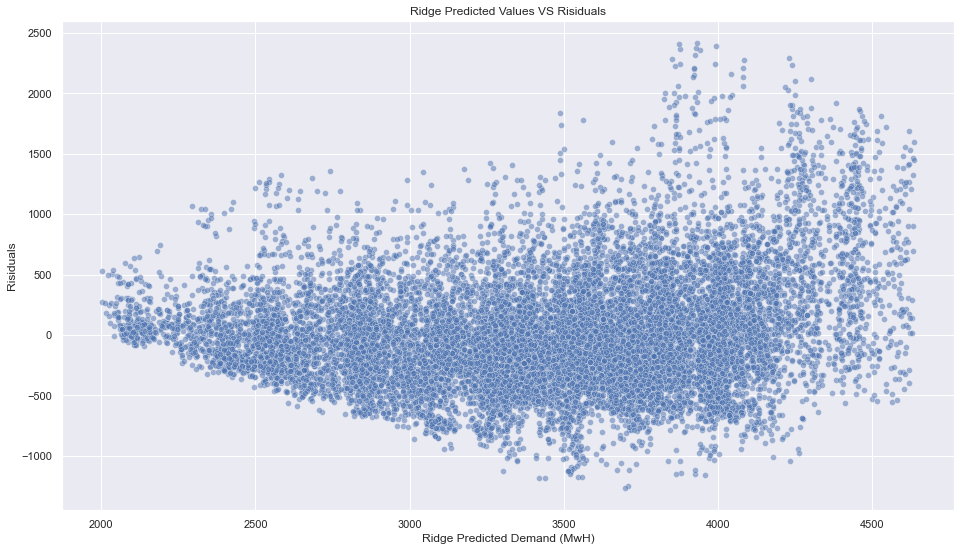

In [24]:
ris = y_test - (ridge.predict(X_test))
plt.figure(figsize=(16,9))
sns.scatterplot(x=(ridge.predict(X_test)), y=ris, alpha=0.5)
plt.title('Ridge Predicted Values VS Risiduals')
plt.ylabel('Risiduals')
plt.xlabel('Ridge Predicted Demand (MwH)')

In [25]:
# Ridge Regression Error Metrics (Training)
error_metrics(ridge.predict(X_train), y_train, model_name='Ridge Regression (Scaled)', test=False)

# Ridge Regression Error Metrics (Test)
error_metrics(ridge.predict(X_test), y_test, model_name='Ridge Regression (Scaled)', test=True)

Error metrics for Ridge Regression (Scaled) 

Root Mean Squared Error (RMSE): 439.573
Mean Absolute Error (MAE): 321.601
Mean Absolute Percentage Error (MAPE): 8.828 %
Variance Score (R2): 0.693
Error metrics for Ridge Regression (Scaled) 

Root Mean Squared Error (RMSE): 456.038
Mean Absolute Error (MAE): 342.424
Mean Absolute Percentage Error (MAPE): 9.827 %
Variance Score (R2): 0.653


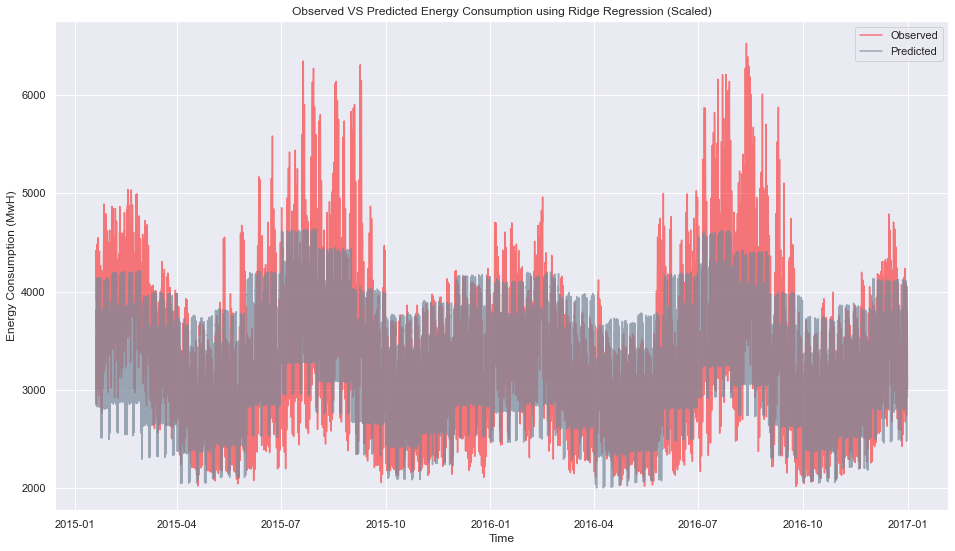

In [26]:
PlotPredictedTS(y_test, ridge.predict(X_test), model_name='Ridge Regression (Scaled)')

## 3.3 Reducing the feature space

In [27]:
CT = df.copy()
CT.head()

zone  demand  drybulb  dewpnt        date  year month  \
ts                                                                          
2004-01-01 00:00:00   CT  3126.0     33.0    26.0  2004-01-01  2004     1   
2004-01-01 01:00:00   CT  2945.0     34.0    26.0  2004-01-01  2004     1   
2004-01-01 02:00:00   CT  2804.0     40.0    26.0  2004-01-01  2004     1   
2004-01-01 03:00:00   CT  2729.0     38.0    23.0  2004-01-01  2004     1   
2004-01-01 04:00:00   CT  2722.0     37.0    21.0  2004-01-01  2004     1   

                    hour day_of_week  day_of_year  weekend  holiday   trend  \
ts                                                                            
2004-01-01 00:00:00    0         Thu            1    False     True  7344.0   
2004-01-01 01:00:00    1         Thu            1    False     True  7345.0   
2004-01-01 02:00:00    2         Thu            1    False     True  7346.0   
2004-01-01 03:00:00    3         Thu            1    False     True  7347.0   
2004-01-01 04:00:00    4         Thu            1    False     True  7348.0   

                    non_working  
ts                               
2004-01-01 00:00:00        True  
2004-01-01 01:00:00        True  
2004-01-01 02:00:00        True  
2004-01-01 03:00:00        True  
2004-01-01 04:00:00        True

In [28]:
def season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

In [29]:
CT['season'] = CT.month.apply(season)
CT.head()

zone  demand  drybulb  dewpnt        date  year month  \
ts                                                                          
2004-01-01 00:00:00   CT  3126.0     33.0    26.0  2004-01-01  2004     1   
2004-01-01 01:00:00   CT  2945.0     34.0    26.0  2004-01-01  2004     1   
2004-01-01 02:00:00   CT  2804.0     40.0    26.0  2004-01-01  2004     1   
2004-01-01 03:00:00   CT  2729.0     38.0    23.0  2004-01-01  2004     1   
2004-01-01 04:00:00   CT  2722.0     37.0    21.0  2004-01-01  2004     1   

                    hour day_of_week  day_of_year  weekend  holiday   trend  \
ts                                                                            
2004-01-01 00:00:00    0         Thu            1    False     True  7344.0   
2004-01-01 01:00:00    1         Thu            1    False     True  7345.0   
2004-01-01 02:00:00    2         Thu            1    False     True  7346.0   
2004-01-01 03:00:00    3         Thu            1    False     True  7347.0   
2004-01-01 04:00:00    4         Thu            1    False     True  7348.0   

                    non_working  season  
ts                                       
2004-01-01 00:00:00        True  Winter  
2004-01-01 01:00:00        True  Winter  
2004-01-01 02:00:00        True  Winter  
2004-01-01 03:00:00        True  Winter  
2004-01-01 04:00:00        True  Winter

In [30]:
def TimeOfDay(x):
    if x in (list(np.arange(7,13))):
        return 'morning'
    elif x in (list(np.arange(13,16))):
        return 'afternoon'
    elif x in (list(np.arange(16,22))):
        return 'evening'
    else:
        return 'night'

In [31]:
CT['time_of_day'] = CT['hour'].apply(TimeOfDay)
CT.head()

zone  demand  drybulb  dewpnt        date  year month  \
ts                                                                          
2004-01-01 00:00:00   CT  3126.0     33.0    26.0  2004-01-01  2004     1   
2004-01-01 01:00:00   CT  2945.0     34.0    26.0  2004-01-01  2004     1   
2004-01-01 02:00:00   CT  2804.0     40.0    26.0  2004-01-01  2004     1   
2004-01-01 03:00:00   CT  2729.0     38.0    23.0  2004-01-01  2004     1   
2004-01-01 04:00:00   CT  2722.0     37.0    21.0  2004-01-01  2004     1   

                    hour day_of_week  day_of_year  weekend  holiday   trend  \
ts                                                                            
2004-01-01 00:00:00    0         Thu            1    False     True  7344.0   
2004-01-01 01:00:00    1         Thu            1    False     True  7345.0   
2004-01-01 02:00:00    2         Thu            1    False     True  7346.0   
2004-01-01 03:00:00    3         Thu            1    False     True  7347.0   
2004-01-01 04:00:00    4         Thu            1    False     True  7348.0   

                    non_working  season time_of_day  
ts                                                   
2004-01-01 00:00:00        True  Winter       night  
2004-01-01 01:00:00        True  Winter       night  
2004-01-01 02:00:00        True  Winter       night  
2004-01-01 03:00:00        True  Winter       night  
2004-01-01 04:00:00        True  Winter       night

In [32]:
cols = ['month', 'day_of_year', 'hour', 'day_of_week', 'season', 'holiday', 'non_working', 'time_of_day']

for c in cols:
    CT[c] = CT[c].astype('category')

In [33]:
CT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113976 entries, 2004-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   zone         113976 non-null  object  
 1   demand       113976 non-null  float64 
 2   drybulb      113976 non-null  float64 
 3   dewpnt       113976 non-null  float64 
 4   date         113976 non-null  object  
 5   year         113976 non-null  int64   
 6   month        113976 non-null  category
 7   hour         113976 non-null  category
 8   day_of_week  113976 non-null  category
 9   day_of_year  113976 non-null  category
 10  weekend      113976 non-null  bool    
 11  holiday      113976 non-null  category
 12  trend        113976 non-null  float64 
 13  non_working  113976 non-null  category
 14  season       113976 non-null  category
 15  time_of_day  113976 non-null  category
dtypes: bool(1), category(8), float64(4), int64(1), object(2)
m

In [34]:
regCols = ['demand', 'year', 'time_of_day', 'non_working', 'drybulb', 'dewpnt', 'season']
CT1_lin = pd.get_dummies(CT[regCols], drop_first = True)
CT1_lin.head()

demand  year  drybulb  dewpnt  time_of_day_evening  \
ts                                                                        
2004-01-01 00:00:00  3126.0  2004     33.0    26.0                    0   
2004-01-01 01:00:00  2945.0  2004     34.0    26.0                    0   
2004-01-01 02:00:00  2804.0  2004     40.0    26.0                    0   
2004-01-01 03:00:00  2729.0  2004     38.0    23.0                    0   
2004-01-01 04:00:00  2722.0  2004     37.0    21.0                    0   

                     time_of_day_morning  time_of_day_night  non_working_True  \
ts                                                                              
2004-01-01 00:00:00                    0                  1                 1   
2004-01-01 01:00:00                    0                  1                 1   
2004-01-01 02:00:00                    0                  1                 1   
2004-01-01 03:00:00                    0                  1                 1   
2004-01-01 04:00:00                    0                  1                 1   

                     season_Spring  season_Summer  season_Winter  
ts                                                                
2004-01-01 00:00:00              0              0              1  
2004-01-01 01:00:00              0              0              1  
2004-01-01 02:00:00              0              0              1  
2004-01-01 03:00:00              0              0              1  
2004-01-01 04:00:00              0              0              1

In [35]:
cols_to_transform = ['drybulb', 'dewpnt', 'year']
X_train, X_test, y_train, y_test = TrainTestSplit(CT1_lin, scale = True, cols_to_transform=cols_to_transform, include_test_scale=False)

## 3.4 Elastic Net Regression

In [36]:
# from turtle import color
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

param_grid = {'l1_ratio': np.linspace(0, 1, 50), 'alpha': np.logspace(-2, 0, 30)}
elastic_net = ElasticNet()
tsCV = TimeSeriesSplit(n_splits=5)
gm_cv = GridSearchCV(elastic_net, param_grid, cv=tsCV)

gm_cv.fit(X_train, y_train)

y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Tuned ElasticNet l1 ratio: {gm_cv.best_params_}')
print(f'Tuned ElasticNet R squared: {r2}')
print(f'Tuned ElasticNet RMSE: {np.sqrt(mse)}')

elastic_net_opt = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio']) 
elastic_net_opt.fit(X_train, y_train)


/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2046365652.327398, tolerance: 1106553.7021785553
  model = cd_fast.enet_coordinate_descent(
/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4066036571.7406025, tolerance: 2149053.8742508185
  model = cd_fast.enet_coordinate_descent(
/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5693052865.408721, tolerance: 3035260.3958810978
  model = cd_fast.enet_coordinate_descent(
/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sk

Tuned ElasticNet l1 ratio: {'alpha': 1.0, 'l1_ratio': 0.9795918367346939}
Tuned ElasticNet R squared: 0.5717716335147331
Tuned ElasticNet RMSE: 506.90916784098044


ElasticNet(l1_ratio=0.9795918367346939)

Text(0.5, 0, 'Features Used')

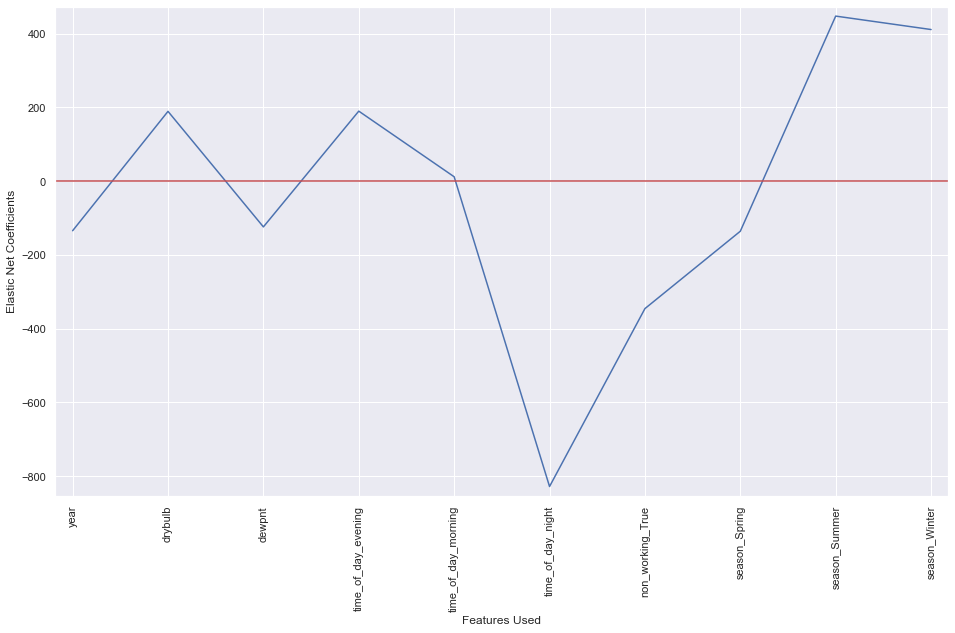

In [37]:
plt.figure(figsize=(16,9))
sns.lineplot(x=(range(len(X_train.columns))), y=elastic_net_opt.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.02)
plt.axhline(0, color='r')
plt.ylabel('Elastic Net Coefficients')
plt.xlabel('Features Used')

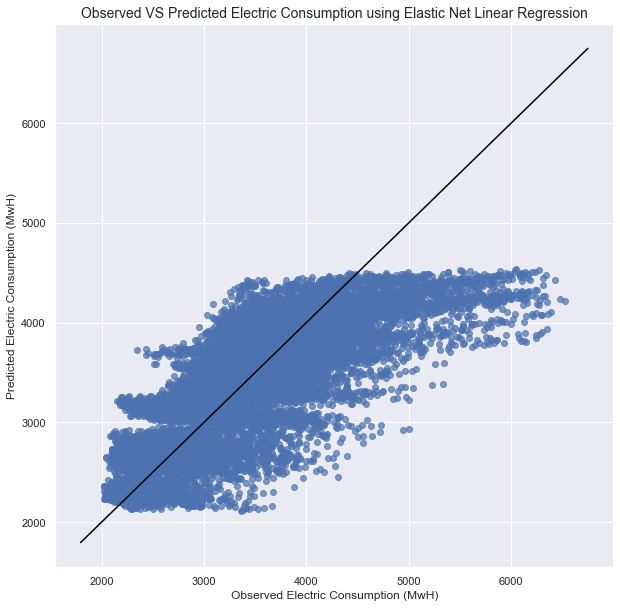

In [38]:
PredTrueReg(elastic_net_opt.predict(X_test), y_test, model_name='Elastic Net Linear Regression')

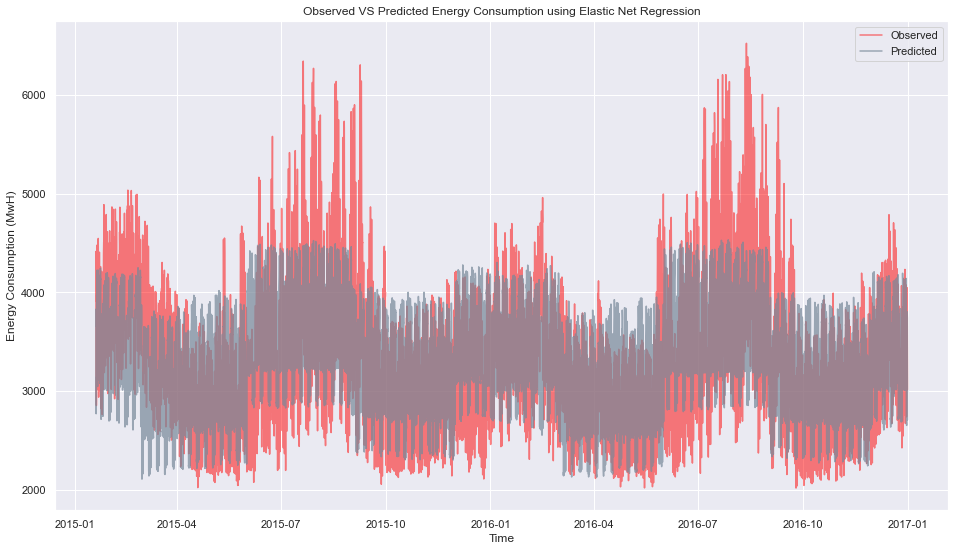

In [39]:
PlotPredictedTS(y_test, elastic_net_opt.predict(X_test), model_name='Elastic Net Regression')

In [40]:
# Elastic Net Error Metrics (Train)
error_metrics(elastic_net_opt.predict(X_train), y_train, model_name='Elastic Net with reduced feature space', test=False)

# Elastic Net Error Metrics (Test)
error_metrics(elastic_net_opt.predict(X_test), y_test, model_name='Elastic Net with reduced feature space', test=True)

Error metrics for Elastic Net with reduced feature space 

Root Mean Squared Error (RMSE): 477.291
Mean Absolute Error (MAE): 363.237
Mean Absolute Percentage Error (MAPE): 10.107 %
Variance Score (R2): 0.638
Error metrics for Elastic Net with reduced feature space 

Root Mean Squared Error (RMSE): 506.909
Mean Absolute Error (MAE): 387.795
Mean Absolute Percentage Error (MAPE): 11.146 %
Variance Score (R2): 0.572


# 4. Random Forest Regression

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
estimators = list(np.linspace(10, 300, 10, endpoint=True, dtype=int))
features = ['auto', 'sqrt']
depth = list(range(1, 6))

random_grid = {'n_estimators': estimators, 'max_features': features, 'max_depth': depth}
print(random_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5]}


In [43]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

tscv = TimeSeriesSplit(n_splits=5)

rf_random = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, cv=tscv, verbose=2, n_jobs=-1)

rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 267, 'max_features': 'sqrt', 'max_depth': 5}

In [44]:
rf_random.score(X_train, y_train)

0.8102938338790844

In [45]:
rf_random.score(X_test, y_test)

0.745352420212616

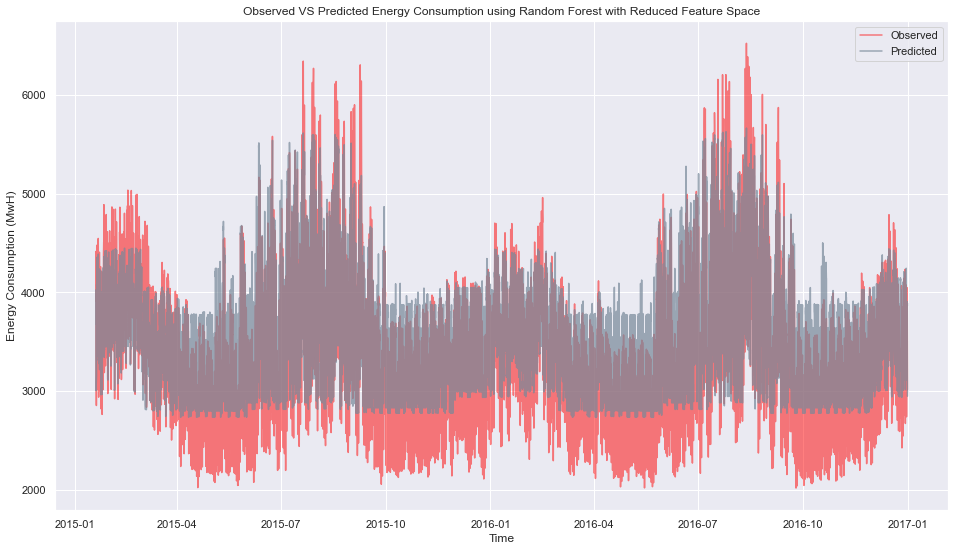

In [46]:
PlotPredictedTS(y_test, rf_random.predict(X_test), model_name='Random Forest with Reduced Feature Space')

In [47]:
error_metrics(rf_random.predict(X_train), y_train, model_name='Random Forest with Reduced Feature Space', test=False)

error_metrics(rf_random.predict(X_test), y_test, model_name='Random Forest with Reduced Feature Space', test=True)

Error metrics for Random Forest with Reduced Feature Space 

Root Mean Squared Error (RMSE): 345.705
Mean Absolute Error (MAE): 273.661
Mean Absolute Percentage Error (MAPE): 7.853 %
Variance Score (R2): 0.81
Error metrics for Random Forest with Reduced Feature Space 

Root Mean Squared Error (RMSE): 390.897
Mean Absolute Error (MAE): 328.501
Mean Absolute Percentage Error (MAPE): 10.48 %
Variance Score (R2): 0.745


# 5. Adding lags as X variables (Elastic Net & Random Forest)

## 5.1 Adding the lagged demand to our data

In [48]:
CT1_lin.head()

demand  year  drybulb  dewpnt  time_of_day_evening  \
ts                                                                        
2004-01-01 00:00:00  3126.0  2004     33.0    26.0                    0   
2004-01-01 01:00:00  2945.0  2004     34.0    26.0                    0   
2004-01-01 02:00:00  2804.0  2004     40.0    26.0                    0   
2004-01-01 03:00:00  2729.0  2004     38.0    23.0                    0   
2004-01-01 04:00:00  2722.0  2004     37.0    21.0                    0   

                     time_of_day_morning  time_of_day_night  non_working_True  \
ts                                                                              
2004-01-01 00:00:00                    0                  1                 1   
2004-01-01 01:00:00                    0                  1                 1   
2004-01-01 02:00:00                    0                  1                 1   
2004-01-01 03:00:00                    0                  1                 1   
2004-01-01 04:00:00                    0                  1                 1   

                     season_Spring  season_Summer  season_Winter  
ts                                                                
2004-01-01 00:00:00              0              0              1  
2004-01-01 01:00:00              0              0              1  
2004-01-01 02:00:00              0              0              1  
2004-01-01 03:00:00              0              0              1  
2004-01-01 04:00:00              0              0              1

In [49]:
# Creating the lag variables | lag1 is demand for the previous hour, lag2 is demand for two hours before, and so on
for i in range(24):
    CT1_lin['lag'+str(i+1)] = CT1_lin['demand'].shift(i+1)

In [50]:
lagged_demand = CT1_lin.dropna()
lagged_demand.head()

demand  year  drybulb  dewpnt  time_of_day_evening  \
ts                                                                        
2004-01-02 00:00:00  2970.0  2004     27.0    24.0                    0   
2004-01-02 01:00:00  2854.0  2004     28.0    25.0                    0   
2004-01-02 02:00:00  2787.0  2004     28.0    25.0                    0   
2004-01-02 03:00:00  2767.0  2004     29.0    26.0                    0   
2004-01-02 04:00:00  2806.0  2004     28.0    26.0                    0   

                     time_of_day_morning  time_of_day_night  non_working_True  \
ts                                                                              
2004-01-02 00:00:00                    0                  1                 0   
2004-01-02 01:00:00                    0                  1                 0   
2004-01-02 02:00:00                    0                  1                 0   
2004-01-02 03:00:00                    0                  1                 0   
2004-01-02 04:00:00                    0                  1                 0   

                     season_Spring  season_Summer  ...   lag15   lag16  \
ts                                                 ...                   
2004-01-02 00:00:00              0              0  ...  3299.0  3106.0   
2004-01-02 01:00:00              0              0  ...  3467.0  3299.0   
2004-01-02 02:00:00              0              0  ...  3565.0  3467.0   
2004-01-02 03:00:00              0              0  ...  3550.0  3565.0   
2004-01-02 04:00:00              0              0  ...  3480.0  3550.0   

                      lag17   lag18   lag19   lag20   lag21   lag22   lag23  \
ts                                                                            
2004-01-02 00:00:00  2954.0  2893.0  2789.0  2722.0  2729.0  2804.0  2945.0   
2004-01-02 01:00:00  3106.0  2954.0  2893.0  2789.0  2722.0  2729.0  2804.0   
2004-01-02 02:00:00  3299.0  3106.0  2954.0  2893.0  2789.0  2722.0  2729.0   
2004-01-02 03:00:00  3467.0  3299.0  3106.0  2954.0  2893.0  2789.0  2722.0   
2004-01-02 04:00:00  3565.0  3467.0  3299.0  3106.0  2954.0  2893.0  2789.0   

                      lag24  
ts                           
2004-01-02 00:00:00  3126.0  
2004-01-02 01:00:00  2945.0  
2004-01-02 02:00:00  2804.0  
2004-01-02 03:00:00  2729.0  
2004-01-02 04:00:00  2722.0  

[5 rows x 35 columns]

## 5.2 Running Elastic Net Regression on lagged data

In [51]:
TransformColumns = ['drybulb', 'dewpnt', 'year']
lagList = []
for i in range(24):
    x = 'lag'+str(i+1)
    lagList.append(x)

TransformColumns = TransformColumns + lagList

In [52]:
X_train, X_test, y_train, y_test = TrainTestSplit(lagged_demand, scale=True, cols_to_transform=TransformColumns)

In [53]:
laggedElasticNet = ElasticNet(l1_ratio=0.9795918367346939, alpha=1)
laggedElasticNet.fit(X_train, y_train)

ElasticNet(alpha=1, l1_ratio=0.9795918367346939)

Text(0.5, 0, 'Features Used')

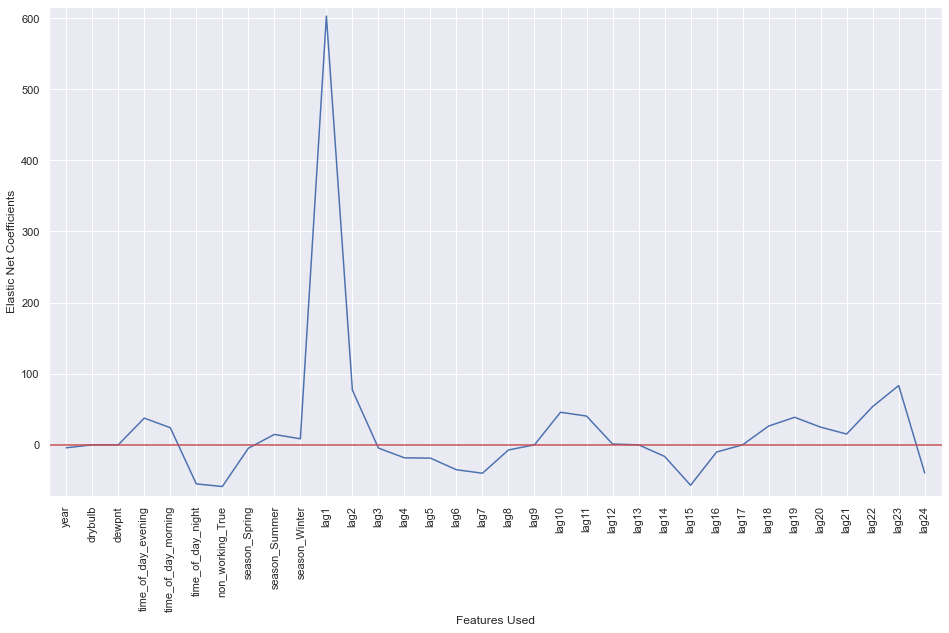

In [54]:
plt.figure(figsize=(16,9))
sns.lineplot(x=(range(len(X_train.columns))), y=laggedElasticNet.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.02)
plt.axhline(0, color='r')
plt.ylabel('Elastic Net Coefficients')
plt.xlabel('Features Used')

## 5.3 Running Random Forest on Lagged Data

In [55]:
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

rflag = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, cv=tscv, verbose=2, n_jobs=-1)

rflag.fit(X_train, y_train)
rflag.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 203, 'max_features': 'auto', 'max_depth': 5}

In [56]:
print('Random Forest | Lagged')
error_metrics(rflag.predict(X_train), y_train, model_name='Random Forest | Lagged', test=False)
error_metrics(rflag.predict(X_test), y_test, model_name='Random Forest | Lagged', test=True)

print('Elastic Net | Lagged')
error_metrics(laggedElasticNet.predict(X_train), y_train, model_name='Elastic Net | Lagged', test=False)
error_metrics(laggedElasticNet.predict(X_test), y_test, model_name='Elastic Net | Lagged', test=True)

Random Forest | Lagged
Error metrics for Random Forest | Lagged 

Root Mean Squared Error (RMSE): 143.1
Mean Absolute Error (MAE): 109.157
Mean Absolute Percentage Error (MAPE): 3.006 %
Variance Score (R2): 0.967
Error metrics for Random Forest | Lagged 

Root Mean Squared Error (RMSE): 139.808
Mean Absolute Error (MAE): 109.557
Mean Absolute Percentage Error (MAPE): 3.287 %
Variance Score (R2): 0.967
Elastic Net | Lagged
Error metrics for Elastic Net | Lagged 

Root Mean Squared Error (RMSE): 110.817
Mean Absolute Error (MAE): 83.898
Mean Absolute Percentage Error (MAPE): 2.293 %
Variance Score (R2): 0.981
Error metrics for Elastic Net | Lagged 

Root Mean Squared Error (RMSE): 100.613
Mean Absolute Error (MAE): 77.056
Mean Absolute Percentage Error (MAPE): 2.242 %
Variance Score (R2): 0.983


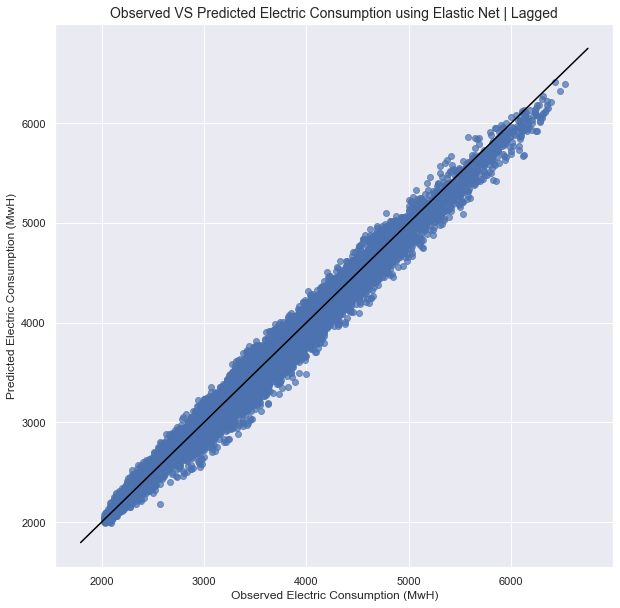

In [57]:
PredTrueReg(laggedElasticNet.predict(X_test), y_test, model_name='Elastic Net | Lagged')

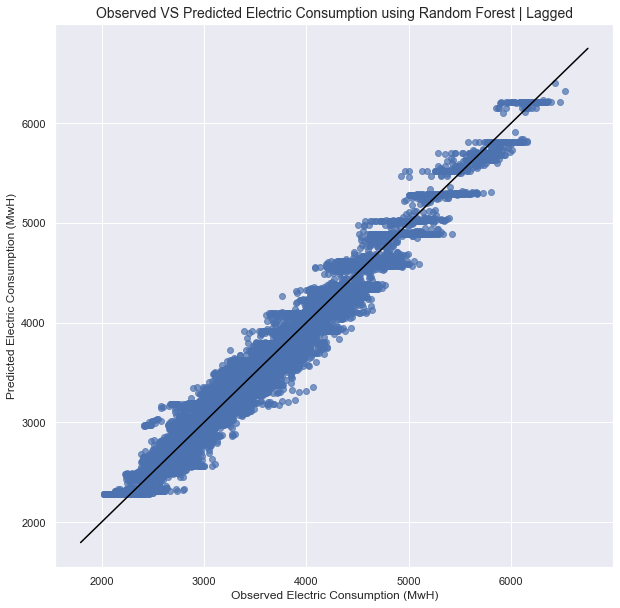

In [58]:
PredTrueReg(rflag.predict(X_test), y_test, model_name='Random Forest | Lagged')

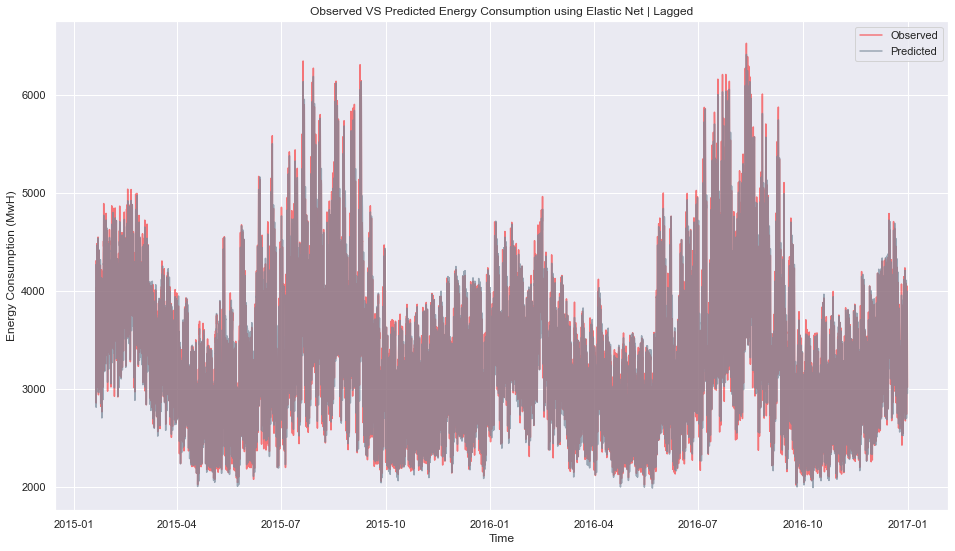

In [59]:
PlotPredictedTS(y_test, laggedElasticNet.predict(X_test), model_name='Elastic Net | Lagged')

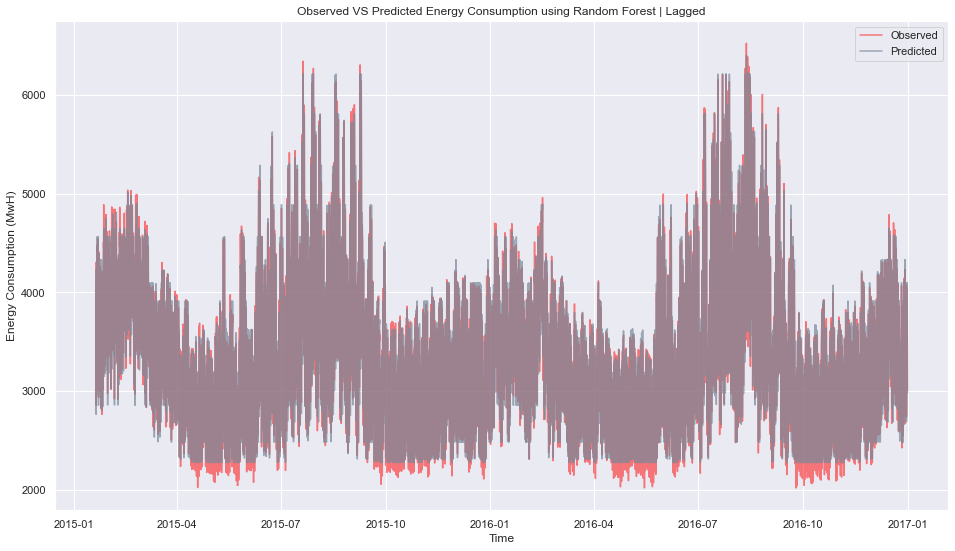

In [60]:
PlotPredictedTS(y_test, rflag.predict(X_test), model_name='Random Forest | Lagged')

# 6. Time Series and Features and Models

## 6.1 Basic Time Series Structure, Stationarity, and Auto Correlation

In [61]:
demandTS = pd.DataFrame(CT1_lin['demand'], columns=['demand'])
demandTS.tail()

demand
ts                           
2016-12-31 19:00:00  3744.918
2016-12-31 20:00:00  3558.586
2016-12-31 21:00:00  3378.466
2016-12-31 22:00:00  3195.386
2016-12-31 23:00:00  3016.453

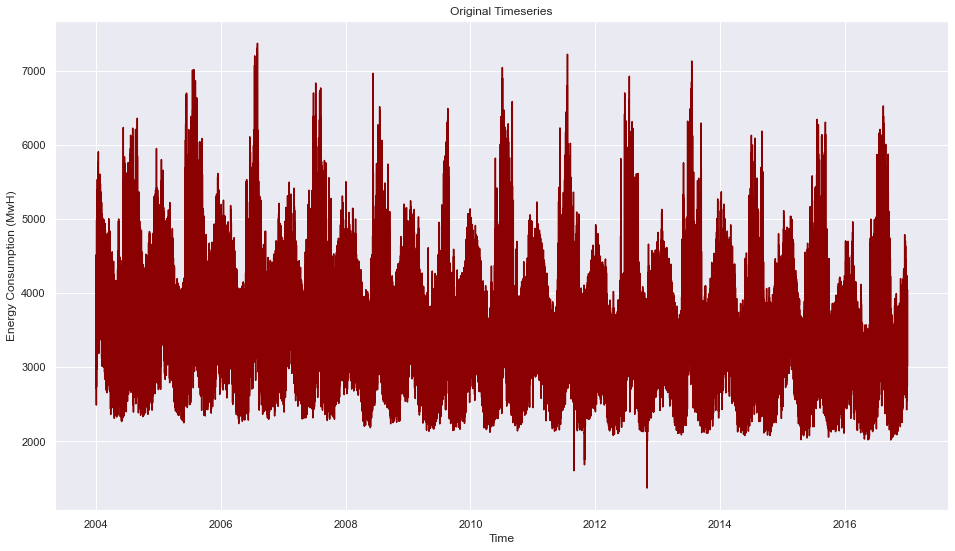

In [62]:
PlotTS(demandTS['demand'], title='Original Timeseries')

In [63]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

ts
2004-01-01 00:00:00   -539.182164
2004-01-01 01:00:00   -684.756011
2004-01-01 02:00:00   -757.329593
2004-01-01 03:00:00   -781.153009
2004-01-01 04:00:00   -741.309457
Name: seasonal, dtype: float64


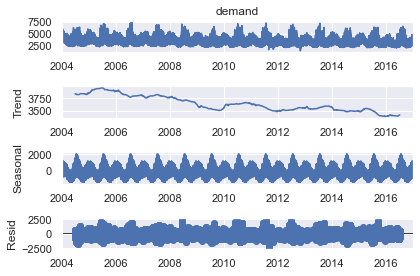

In [64]:
decompose = sm.tsa.seasonal_decompose(demandTS['demand'], period=8760)
print(decompose.seasonal.head())

p = decompose.plot()

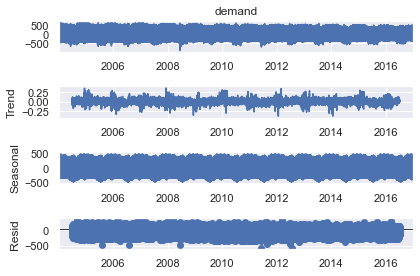

In [65]:
decompose_diff = sm.tsa.seasonal_decompose(demandTS['demand'].diff().dropna(), period=8760)
p = decompose_diff.plot()

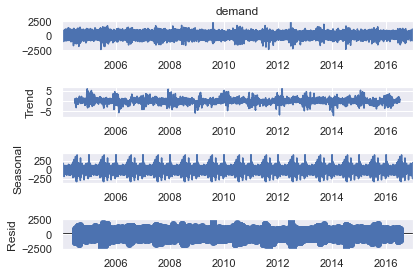

In [66]:
decompose_diff = sm.tsa.seasonal_decompose(demandTS['demand'].diff(24).dropna(), period=8760)
p = decompose_diff.plot()

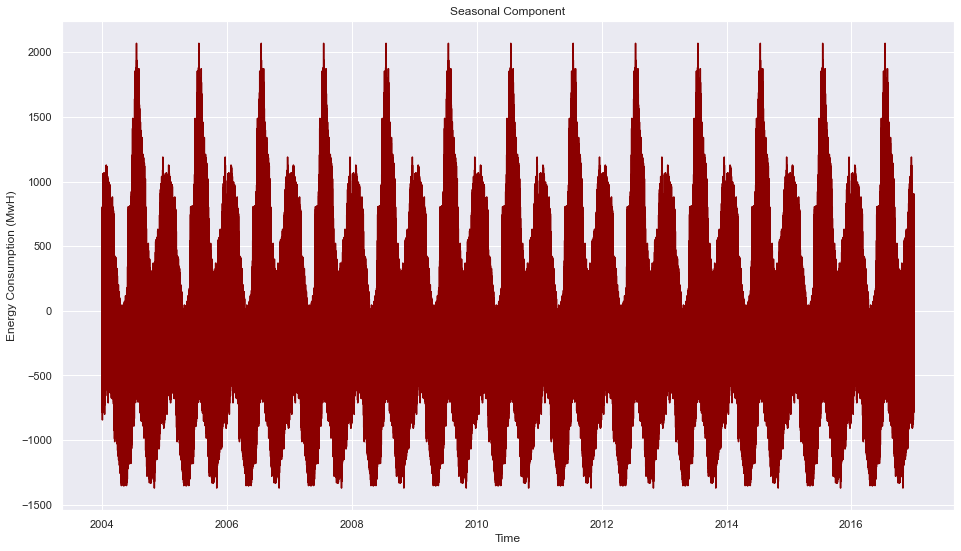

In [67]:
demandTS['seasonal'] = decompose.seasonal
PlotTS(demandTS['seasonal'], title='Seasonal Component')

<AxesSubplot:xlabel='ts'>

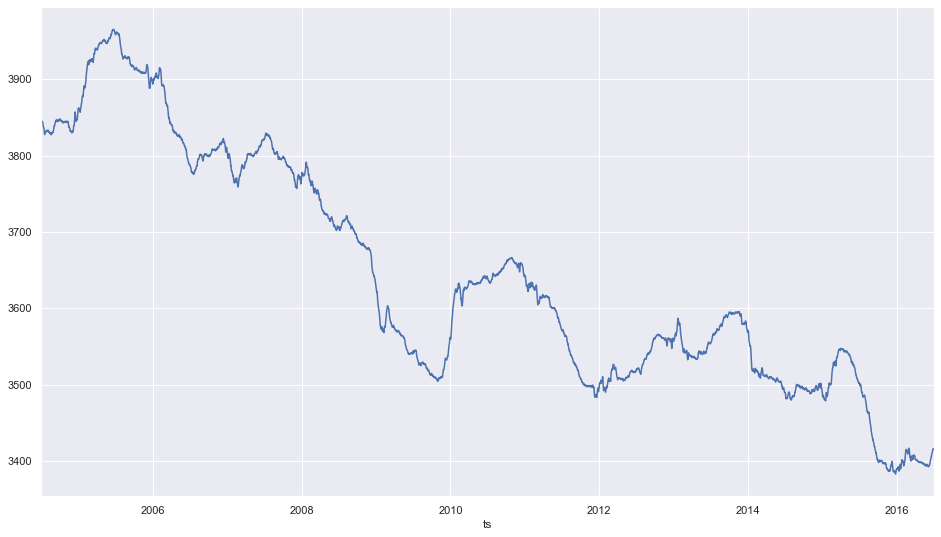

In [68]:
demandTS['trend'] = decompose.trend
demandTS['trend'].dropna().plot(figsize=(16,9))

<AxesSubplot:xlabel='ts'>

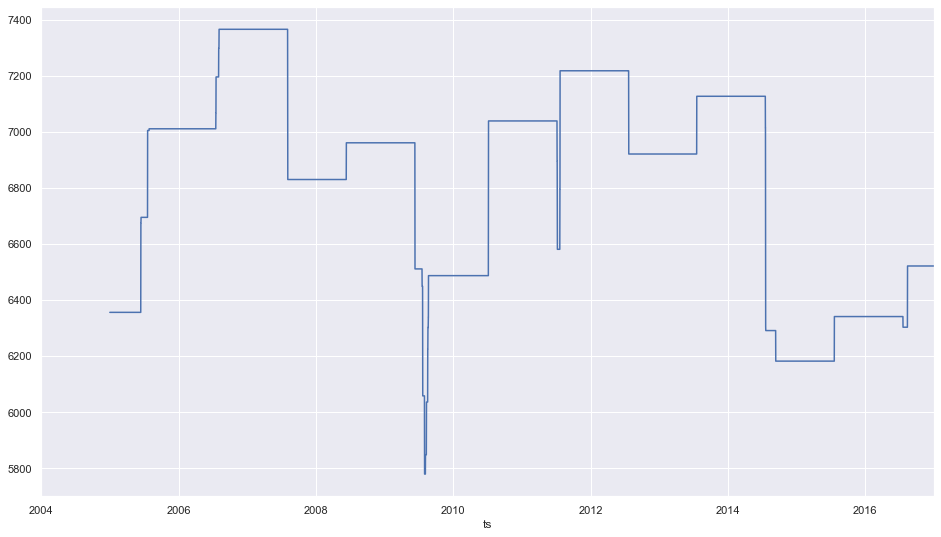

In [69]:
df['demand'].rolling(window=8760).max().plot(figsize=(16,9))

### 6.1.1 Dicky Fuller Test for Stationarity

In [70]:
from statsmodels.tsa.stattools import adfuller

def adf(ts):
    results = adfuller(ts)
    print('t-stat:', results[0])
    print('p-value:', results[1])
    print('#lags used:', results[2])
    print('critical values:', results[4])

In [71]:
adf(demandTS['demand'])

t-stat: -16.078608878006676
p-value: 5.408991732283845e-29
#lags used: 70
critical values: {'1%': -3.4304074114163075, '5%': -2.861565374980681, '10%': -2.5667835062083393}


In [72]:
adf(demandTS['demand'].diff().dropna())

t-stat: -49.291617597384416
p-value: 0.0
#lags used: 70
critical values: {'1%': -3.4304074119203523, '5%': -2.8615653752034587, '10%': -2.566783506326917}


In [73]:
adf(demandTS['demand'].diff(24).dropna())

t-stat: -49.81855510749919
p-value: 0.0
#lags used: 70
critical values: {'1%': -3.4304074235158244, '5%': -2.861565380328433, '10%': -2.5667835090547686}


### 6.1.2 Correlation with Past Values

In [74]:
from statsmodels. graphics.tsaplots import plot_acf, plot_pacf

In [75]:
def acf_plots(ts, lags, figsize=(16,9)):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    plot_acf(ts, lags=lags, zero=False, ax=ax1, alpha=0.05)

    plot_pacf(ts, lags=lags, zero=False, ax=ax2, alpha=0.05)



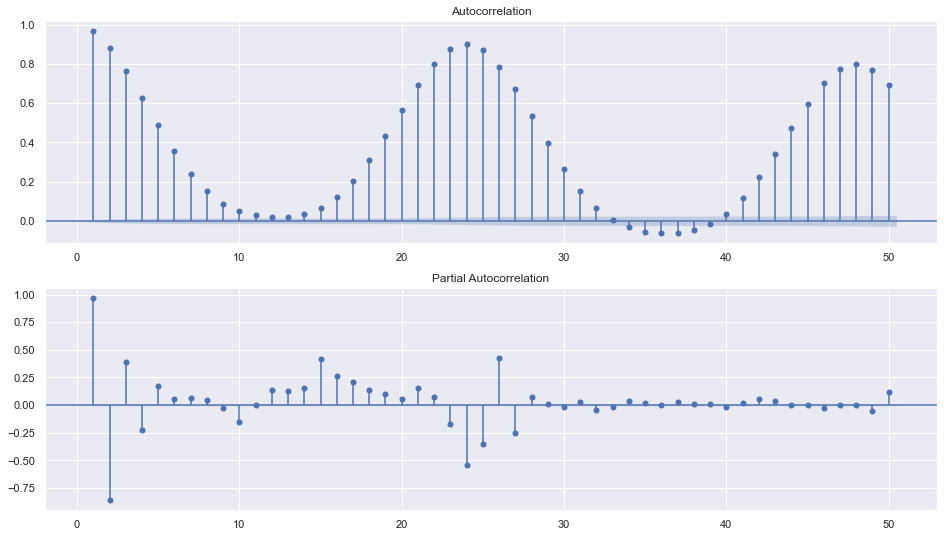

In [76]:
acf_plots(demandTS['demand'], lags=50)

In [77]:
statTS = demandTS['demand']
statTS = statTS.diff().dropna()
statTS = statTS.diff(24).dropna()
statTS = statTS.diff(8760).dropna()

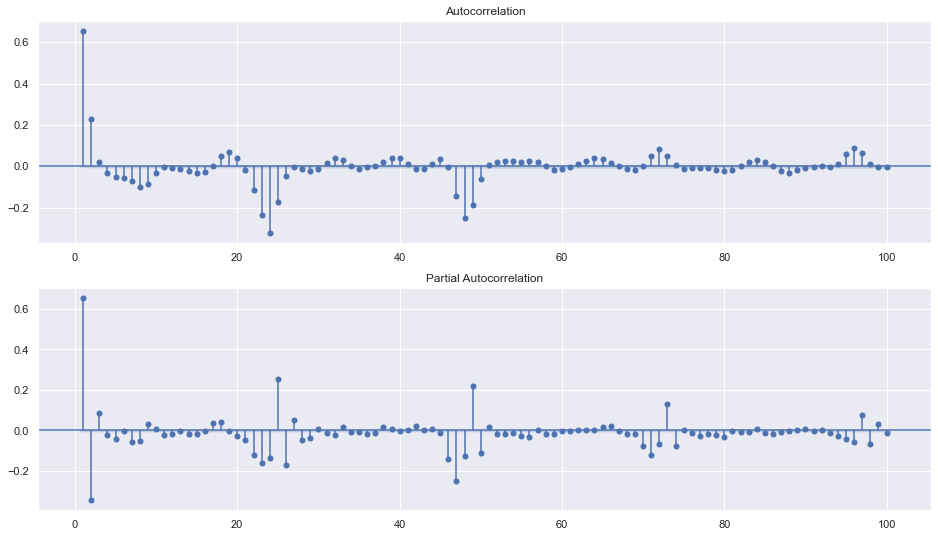

In [78]:
acf_plots(statTS, lags=100)

In [79]:
def add_fourier(df, year_k, week_k, day_k):
    for k in range(1, year_k+1):
        df['year_sin'+str(k)] = np.sin(2 * k * np.pi * (df.index.dayofyear)/365.25)
        df['year_cos'+str(k)] = np.cos(2 * k * np.pi * (df.index.dayofyear)/365.25)

    for k in range(1, week_k+1):
        df['week_sin'+str(k)] = np.sin(2 * k * np.pi * (df.index.day_of_week)/7)
        df['week_cos'+str(k)] = np.cos(2 * k * np.pi * (df.index.day_of_week)/7)

    for k in range(1, day_k+1):
        df['day_sin'+str(k)] = np.sin(2 * k * np.pi * (df.index.hour)/24)
        df['day_cos'+str(k)] = np.cos(2 * k * np.pi * (df.index.hour)/24)

In [80]:
import warnings
warnings.filterwarnings('ignore')

demandFourier = df.drop(['date', 'trend', 'day_of_week', 'day_of_year', 'zone', 'weekend', 'holiday', 'year', 'month', 'hour'], axis=1)
demandFourier['non_working'] = demandFourier.apply(lambda x: 1 if (x['non_working'] == True) else 0, axis=1)
add_fourier(demandFourier, 5, 5, 5)
demandFourier.head()

demand  drybulb  dewpnt  non_working  year_sin1  \
ts                                                                     
2004-01-01 00:00:00  3126.0     33.0    26.0            1   0.017202   
2004-01-01 01:00:00  2945.0     34.0    26.0            1   0.017202   
2004-01-01 02:00:00  2804.0     40.0    26.0            1   0.017202   
2004-01-01 03:00:00  2729.0     38.0    23.0            1   0.017202   
2004-01-01 04:00:00  2722.0     37.0    21.0            1   0.017202   

                     year_cos1  year_sin2  year_cos2  year_sin3  year_cos3  \
ts                                                                           
2004-01-01 00:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 01:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 02:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 03:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 04:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   

                     ...  day_sin1  day_cos1  day_sin2      day_cos2  \
ts                   ...                                               
2004-01-01 00:00:00  ...  0.000000  1.000000  0.000000  1.000000e+00   
2004-01-01 01:00:00  ...  0.258819  0.965926  0.500000  8.660254e-01   
2004-01-01 02:00:00  ...  0.500000  0.866025  0.866025  5.000000e-01   
2004-01-01 03:00:00  ...  0.707107  0.707107  1.000000  6.123234e-17   
2004-01-01 04:00:00  ...  0.866025  0.500000  0.866025 -5.000000e-01   

                         day_sin3      day_cos3      day_sin4  day_cos4  \
ts                                                                        
2004-01-01 00:00:00  0.000000e+00  1.000000e+00  0.000000e+00       1.0   
2004-01-01 01:00:00  7.071068e-01  7.071068e-01  8.660254e-01       0.5   
2004-01-01 02:00:00  1.000000e+00  6.123234e-17  8.660254e-01      -0.5   
2004-01-01 03:00:00  7.071068e-01 -7.071068e-01  1.224647e-16      -1.0   
2004-01-01 04:00:00  1.224647e-16 -1.000000e+00 -8.660254e-01      -0.5   

                     day_sin5  day_cos5  
ts                                       
2004-01-01 00:00:00  0.000000  1.000000  
2004-01-01 01:00:00  0.965926  0.258819  
2004-01-01 02:00:00  0.500000 -0.866025  
2004-01-01 03:00:00 -0.707107 -0.707107  
2004-01-01 04:00:00 -0.866025  0.500000  

[5 rows x 34 columns]

<AxesSubplot:xlabel='ts'>

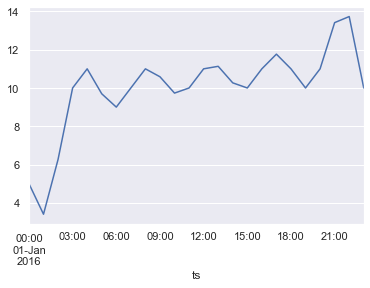

In [81]:
pd.plotting.register_matplotlib_converters()
(1-demandFourier.loc['01-01-2016':'01-01-2016', [col for col in demandFourier if col.startswith('day')]]).sum(axis = 1).plot()

<AxesSubplot:xlabel='ts'>

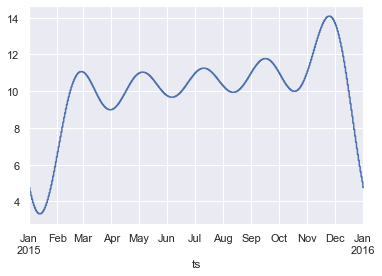

In [82]:
(1-demandFourier.loc['01-01-2015':'01-01-2016', [col for col in demandFourier if col.startswith('year')]]).sum(axis = 1).plot()

<AxesSubplot:xlabel='ts'>

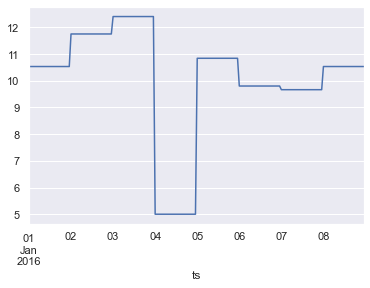

In [83]:
(1-demandFourier.loc['01-01-2016':'01-08-2016', [col for col in demandFourier if col.startswith('week')]]).sum(axis = 1).plot()

## 6.2 SARIMAX

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as param_grid

In [85]:
demandFourier.columns

Index(['demand', 'drybulb', 'dewpnt', 'non_working', 'year_sin1', 'year_cos1',
       'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'year_sin4',
       'year_cos4', 'year_sin5', 'year_cos5', 'week_sin1', 'week_cos1',
       'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4',
       'week_cos4', 'week_sin5', 'week_cos5', 'day_sin1', 'day_cos1',
       'day_sin2', 'day_cos2', 'day_sin3', 'day_cos3', 'day_sin4', 'day_cos4',
       'day_sin5', 'day_cos5'],
      dtype='object')

In [86]:
cols = ['drybulb', 'dewpnt']
X_train, X_test, y_train, y_test = TrainTestSplit(demandFourier, scale=True, cols_to_transform=cols)

In [87]:
scalar1 = StandardScaler()
y_train = pd.DataFrame(scalar1.fit_transform(y_train.values.reshape(-1,1)), index=y_train.index, columns = ['demand'])

In [88]:
from pmdarima import auto_arima

In [89]:
# stepwise_model = auto_arima(y_train, start_p=0, start_q=0, max_p=2, max_q=2, X=X_train, seasonal=True, m=24, D=1, start_P=1, start_Q=1, max_P=1, max_Q=1, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

In [90]:
# stepwise_model = auto_arima(y_train, start_p=0, start_q=0, max_p=1, max_q=1, X=X_train, seasonal=True, m=24, D=1, start_P=1, start_Q=1, max_P=1, max_Q=1, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

In [91]:
model = SARIMAX(y_train, order=(2,1,1), seasonal_order=(1,0,1,24), exog=X_train, trend='c')

In [92]:
restults = model.fit()
restults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             demand   No. Observations:                96879
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 24)   Log Likelihood              132221.770
Date:                            Tue, 06 Sep 2022   AIC                        -264363.540
Time:                                    14:04:21   BIC                        -263984.292
Sample:                                01-01-2004   HQIC                       -264248.283
                                     - 01-19-2015                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    3.105e-05      0.000      0.170      0.865      -0.000       0.000
drybulb        -0.0061      0.001     -5.582      0.000      -0.008      -0.004
dewpnt         -0.0029      0.001     -2.549      0.011      -0.005      -0.001
non_working    -0.0051      0.004     -1.319      0.187      -0.013       0.002
year_sin1       3.4717      0.392      8.858      0.000       2.704       4.240
year_cos1      -1.3772      0.452     -3.044      0.002      -2.264      -0.490
year_sin2      -1.1281      0.199     -5.659      0.000      -1.519      -0.737
year_cos2       0.3545      0.211      1.682      0.093      -0.059       0.768
year_sin3      -0.0213      0.128     -0.167      0.868      -0.272       0.229
year_cos3      -0.2217      0.140     -1.585      0.113      -0.496       0.052
year_sin4      -0.1065      0.094     -1.132      0.258      -0.291       0.078
year_cos4      -0.0440      0.095     -0.462      0.644      -0.231       0.143
year_sin5      -0.0072      0.071     -0.101      0.920      -0.146       0.132
year_cos5      -0.0805      0.072     -1.118      0.263      -0.222       0.061
week_sin1      -0.0037      0.002     -1.489      0.137      -0.008       0.001
week_cos1      -0.0019      0.002     -1.207      0.227      -0.005       0.001
week_sin2      -0.0056      0.000    -12.616      0.000      -0.006      -0.005
week_cos2   -6.916e-05      0.001     -0.107      0.915      -0.001       0.001
week_sin3      -0.0120      0.000    -38.024      0.000      -0.013      -0.011
week_cos3    9.058e-05      0.000      0.339      0.735      -0.000       0.001
week_sin4      -0.0137      0.000    -43.306      0.000      -0.014      -0.013
week_cos4    9.058e-05      0.000      0.339      0.735      -0.000       0.001
week_sin5      -0.0068      0.000    -15.513      0.000      -0.008      -0.006
week_cos5   -6.916e-05      0.001     -0.107      0.915      -0.001       0.001
day_sin1       -0.6150      0.016    -38.926      0.000      -0.646      -0.584
day_cos1       -0.6711      0.012    -54.832      0.000      -0.695      -0.647
day_sin2       -0.3425      0.007    -48.969      0.000      -0.356      -0.329
day_cos2       -0.1484      0.008    -19.130      0.000      -0.164      -0.133
day_sin3        0.0215      0.005      4.314      0.000       0.012       0.031
day_cos3       -0.0095      0.005     -2.052      0.040      -0.019      -0.000
day_sin4        0.0435      0.003     14.670      0.000       0.038       0.049
day_cos4       -0.0055      0.003     -1.918      0.055      -0.011       0.000
day_sin5        0.0160      0.002      8.831      0.000       0.012       0.019
day_cos5       -0.0385      0.002    -21.608      0.000      -0.042      -0.035
ar.L1           0.7393      0.007    112.599      0.000       0.726       0.752
ar.L2          -0.3032      0.005    -60.417      0.000      -0.313      -0.293
ma.L1        

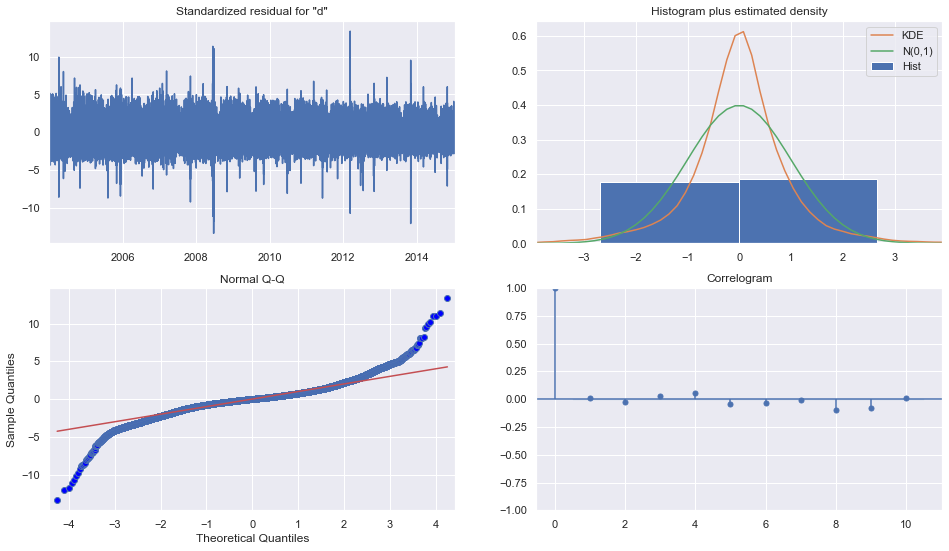

In [93]:
p = restults.plot_diagnostics(figsize=(16,9))

In [94]:
pred = restults.get_prediction(start=X_train.index[-24*7], end=X_train.index[-1], 
                              dynamic=True, exog=X_train.iloc[-24*7:, :])
pred_ci = pred.conf_int()

pred1 = scalar1.inverse_transform(pred.predicted_mean)
pred_ci1 = scalar1.inverse_transform(pred.conf_int())

y_actual_train = np.squeeze(scalar1.inverse_transform(y_train))
y_actual_train = pd.Series(y_actual_train, index = X_train.index )

pred1 = pd.Series(pred1, index = X_train.iloc[-24*7:, :].index )
pred_ci1 = pd.DataFrame(pred_ci1, index = pred1.index, columns = ['lower demand', 'upper demand'])

lower_limits = pred_ci1.loc[:,'lower demand']
upper_limits = pred_ci1.loc[:,'upper demand']

In [95]:
error_metrics(pred1, y_actual_train.iloc[-24*7:], model_name='SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week', test=False)

Error metrics for SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week 

Root Mean Squared Error (RMSE): 445.551
Mean Absolute Error (MAE): 355.17
Mean Absolute Percentage Error (MAPE): 9.51 %
Variance Score (R2): 0.269


Text(0.5, 1.0, 'SARIMAX Model on Training Set: Predicting the last week of the dataset')

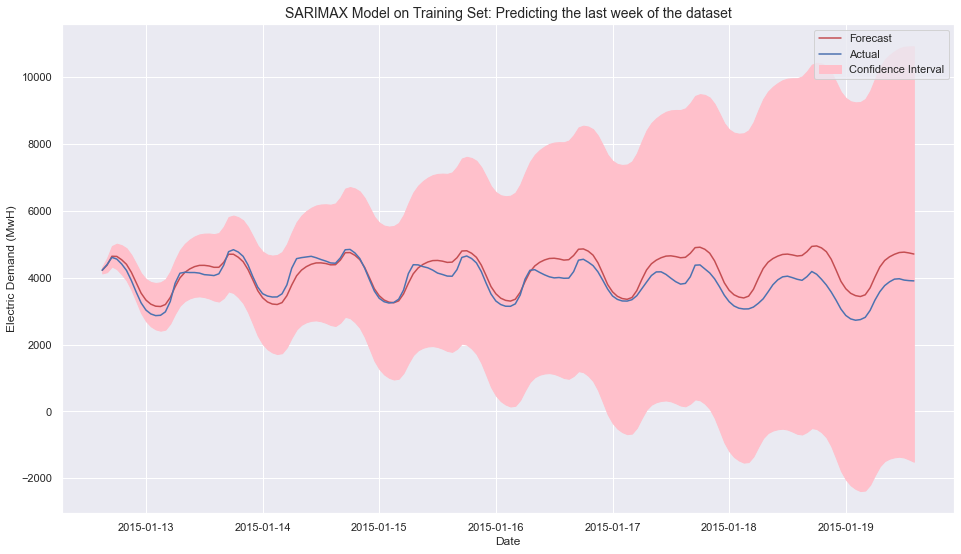

In [96]:
plt.figure(figsize=(16,9))
plt.plot(pred1.index, pred1.values, color='r', label='Forecast')
plt.plot(y_actual_train.iloc[-24*7:].index, y_actual_train.iloc[-24*7:], label='Actual')
plt.fill_between(upper_limits.index, lower_limits, upper_limits, color='pink', label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Electric Demand (MwH)')
plt.legend()
plt.title('SARIMAX Model on Training Set: Predicting the last week of the dataset', fontsize=14)

In [97]:
pred = restults.get_forecast(steps=168, exog=X_test.iloc[:168, :])
predCI = pred.conf_int()

predReal = scalar1.inverse_transform(pred.predicted_mean)
predCIReal = scalar1.inverse_transform(pred.conf_int())

y_actual = y_test.iloc[:168]

predReal = pd.Series(predReal, index=X_test.iloc[:168, :].index)
predCIReal = pd.DataFrame(predCIReal, index=predReal.index, columns=['Lower Demand', 'Upper Demand'])

lower = predCIReal.loc[:, 'Lower Demand']
upper = predCIReal.loc[:, 'Upper Demand']

Text(0.5, 1.0, 'SARIMAX Model on Testing Set: Predicting the first week of the dataset')

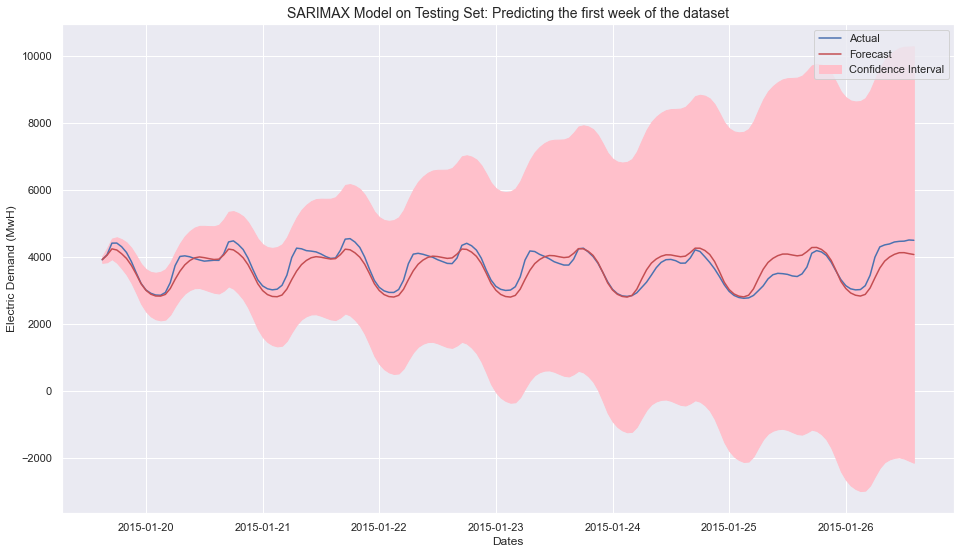

In [98]:
plt.figure(figsize=(16,9))
plt.plot(y_actual.index, y_actual, label='Actual')
plt.plot(predReal.index, predReal.values, color='r', label='Forecast')
plt.fill_between(upper.index, lower, upper, color='pink', label='Confidence Interval')

plt.xlabel('Dates')
plt.ylabel('Electric Demand (MwH)')
plt.legend()
plt.title('SARIMAX Model on Testing Set: Predicting the first week of the dataset', fontsize=14)


In [99]:
error_metrics(predReal, y_actual, 'SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week', test=True)

Error metrics for SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week 

Root Mean Squared Error (RMSE): 264.214
Mean Absolute Error (MAE): 203.357
Mean Absolute Percentage Error (MAPE): 5.451 %
Variance Score (R2): 0.728


## 6.3 FB Prophet

In [100]:
demandFourier.head()

demand  drybulb  dewpnt  non_working  year_sin1  \
ts                                                                     
2004-01-01 00:00:00  3126.0     33.0    26.0            1   0.017202   
2004-01-01 01:00:00  2945.0     34.0    26.0            1   0.017202   
2004-01-01 02:00:00  2804.0     40.0    26.0            1   0.017202   
2004-01-01 03:00:00  2729.0     38.0    23.0            1   0.017202   
2004-01-01 04:00:00  2722.0     37.0    21.0            1   0.017202   

                     year_cos1  year_sin2  year_cos2  year_sin3  year_cos3  \
ts                                                                           
2004-01-01 00:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 01:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 02:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 03:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 04:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   

                     ...  day_sin1  day_cos1  day_sin2      day_cos2  \
ts                   ...                                               
2004-01-01 00:00:00  ...  0.000000  1.000000  0.000000  1.000000e+00   
2004-01-01 01:00:00  ...  0.258819  0.965926  0.500000  8.660254e-01   
2004-01-01 02:00:00  ...  0.500000  0.866025  0.866025  5.000000e-01   
2004-01-01 03:00:00  ...  0.707107  0.707107  1.000000  6.123234e-17   
2004-01-01 04:00:00  ...  0.866025  0.500000  0.866025 -5.000000e-01   

                         day_sin3      day_cos3      day_sin4  day_cos4  \
ts                                                                        
2004-01-01 00:00:00  0.000000e+00  1.000000e+00  0.000000e+00       1.0   
2004-01-01 01:00:00  7.071068e-01  7.071068e-01  8.660254e-01       0.5   
2004-01-01 02:00:00  1.000000e+00  6.123234e-17  8.660254e-01      -0.5   
2004-01-01 03:00:00  7.071068e-01 -7.071068e-01  1.224647e-16      -1.0   
2004-01-01 04:00:00  1.224647e-16 -1.000000e+00 -8.660254e-01      -0.5   

                     day_sin5  day_cos5  
ts                                       
2004-01-01 00:00:00  0.000000  1.000000  
2004-01-01 01:00:00  0.965926  0.258819  
2004-01-01 02:00:00  0.500000 -0.866025  
2004-01-01 03:00:00 -0.707107 -0.707107  
2004-01-01 04:00:00 -0.866025  0.500000  

[5 rows x 34 columns]

In [101]:
X_train, X_test, y_train, y_test = TrainTestSplit(demandFourier[['demand', 'drybulb', 'dewpnt', 'non_working']], scale=False, include_test_scale=False)

In [102]:
def prophetFormat(X_train, X_test, y_train, y_test):
    data_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    data_train = data_train.reset_index().rename(columns = {'demand':'y', 'ts':'ds'})
    data_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
    data_test = data_test.reset_index().rename(columns= {'demand':'y', 'ts':'ds'})
    return data_train, data_test

In [103]:
trainData, testData = prophetFormat(X_train, X_test, y_train, y_test)

In [104]:
trainData.tail()

ds  drybulb  dewpnt  non_working       y
96874 2015-01-19 10:00:00     40.0    29.0            1  3958.0
96875 2015-01-19 11:00:00     39.0    27.0            1  3970.0
96876 2015-01-19 12:00:00     40.0    27.0            1  3930.0
96877 2015-01-19 13:00:00     41.0    25.0            1  3914.0
96878 2015-01-19 14:00:00     41.0    24.0            1  3906.0

In [105]:
from fbprophet import Prophet

In [106]:
prophet = Prophet(growth='linear', interval_width=0.95, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='additive')

In [107]:
prophet.add_regressor('drybulb', prior_scale=20, mode='additive', standardize=True)
prophet.add_regressor('dewpnt', prior_scale=1, mode='additive', standardize=True)
prophet.add_regressor('non_working', prior_scale=10, mode='additive', standardize='auto')

In [108]:
prophet.fit(trainData)

In [109]:
future = prophet.make_future_dataframe(periods=len(testData), freq='h', include_history=True)
future = pd.merge(future, trainData.append(testData).drop('y', axis=1), on ='ds')


In [110]:
future.tail()

ds  drybulb  dewpnt  non_working
113971 2016-12-31 19:00:00     40.0    29.0            1
113972 2016-12-31 20:00:00     41.0    30.0            1
113973 2016-12-31 21:00:00     38.0    32.0            1
113974 2016-12-31 22:00:00     37.0    32.0            1
113975 2016-12-31 23:00:00     37.0    32.0            1

In [111]:
forecast = prophet.predict(future)

In [112]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat  yhat_lower   yhat_upper
113971 2016-12-31 19:00:00  3817.021866  927.426670  6731.138714
113972 2016-12-31 20:00:00  3692.442763  604.329436  6603.127472
113973 2016-12-31 21:00:00  3421.473294  524.564728  6332.721243
113974 2016-12-31 22:00:00  3092.230342  140.056145  5893.044846
113975 2016-12-31 23:00:00  2772.076977 -111.468711  5593.653095

Text(52.0, 0.5, 'Electric Demand (MwH)')

<Figure size 1152x648 with 0 Axes>

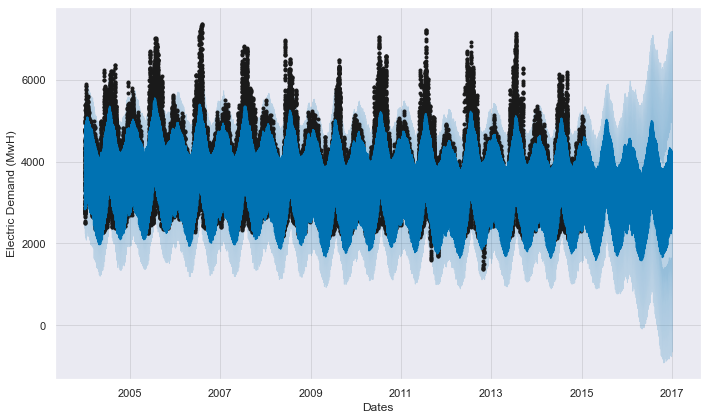

In [113]:
plt.figure(figsize=(16,9))
prophet.plot(forecast, uncertainty=True)
plt.xlabel('Dates')
plt.ylabel('Electric Demand (MwH)')

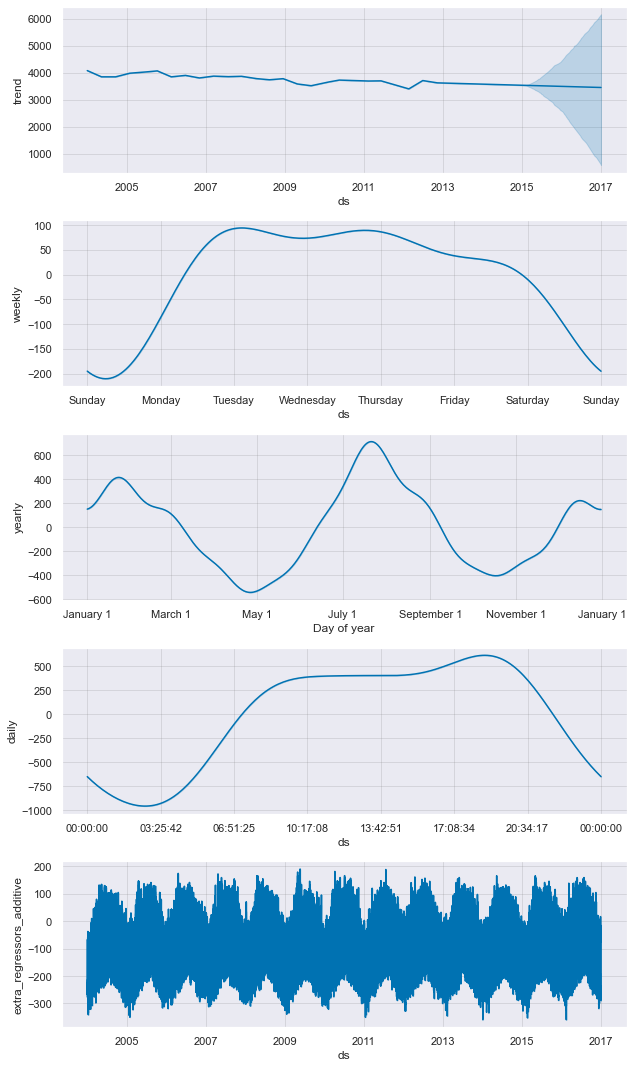

In [114]:
p = prophet.plot_components(forecast)

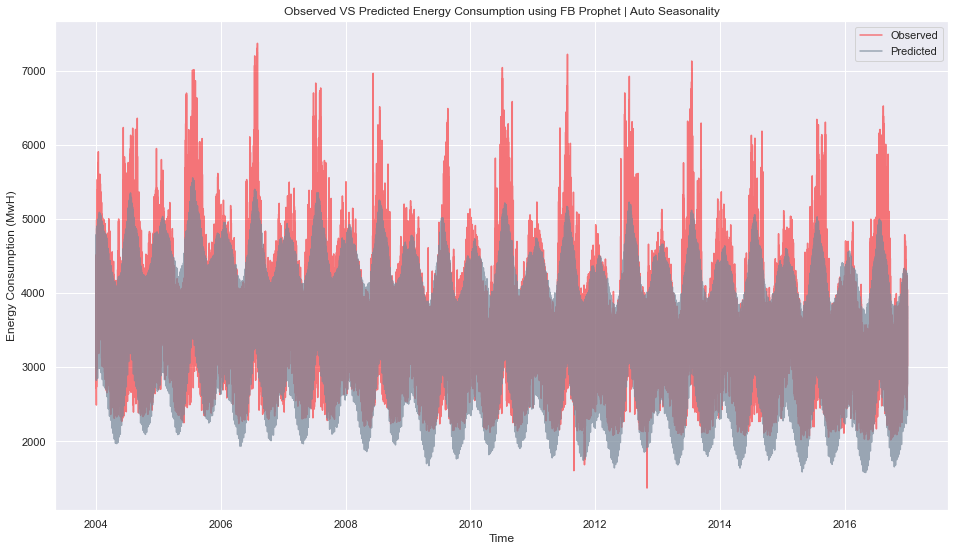

In [115]:
PlotPredictedTS(trainData.append(testData).set_index('ds')['y'], forecast.set_index('ds')['yhat'], model_name='FB Prophet | Auto Seasonality')

In [116]:
from fbprophet.diagnostics import cross_validation

In [117]:
len(y_train) * 2//3

64586

In [118]:
dfCrossVal = cross_validation(prophet, initial='64576 hours', period='3200 hours', horizon='169 hours')
dfCrossVal.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2011-05-20 05:00:00 and 2015-01-12 13:00:00
100%|██████████| 11/11 [28:22<00:00, 154.80s/it]


ds         yhat   yhat_lower   yhat_upper       y  \
0 2011-05-20 06:00:00  2986.476864  2270.098403  3649.602542  3021.0   
1 2011-05-20 07:00:00  3301.658818  2555.946029  3982.536050  3402.0   
2 2011-05-20 08:00:00  3555.606995  2769.221052  4273.797853  3579.0   
3 2011-05-20 09:00:00  3700.219199  2964.880362  4369.763140  3673.0   
4 2011-05-20 10:00:00  3763.320059  3103.582289  4457.390058  3758.0   

               cutoff  
0 2011-05-20 05:00:00  
1 2011-05-20 05:00:00  
2 2011-05-20 05:00:00  
3 2011-05-20 05:00:00  
4 2011-05-20 05:00:00

In [119]:
error_metrics(dfCrossVal['yhat'], dfCrossVal['y'], model_name='FB Prophtet with auto seasonality | One Week Ahead', test=False)

Error metrics for FB Prophtet with auto seasonality | One Week Ahead 

Root Mean Squared Error (RMSE): 446.689
Mean Absolute Error (MAE): 330.386
Mean Absolute Percentage Error (MAPE): 9.016 %
Variance Score (R2): 0.635


In [120]:
error_metrics(forecast.iloc[-len(testData):]['yhat'], testData['y'], model_name='FB Prophtet with auto seasonality | One Week Ahead', test=True)

Error metrics for FB Prophtet with auto seasonality | One Week Ahead 

Root Mean Squared Error (RMSE): 422.457
Mean Absolute Error (MAE): 318.426
Mean Absolute Percentage Error (MAPE): 9.056 %
Variance Score (R2): 0.703


# 7. Regression Models using Fourier Terms

## 7.1 Elastic Net Regression

In [121]:
demandFourier.head()

demand  drybulb  dewpnt  non_working  year_sin1  \
ts                                                                     
2004-01-01 00:00:00  3126.0     33.0    26.0            1   0.017202   
2004-01-01 01:00:00  2945.0     34.0    26.0            1   0.017202   
2004-01-01 02:00:00  2804.0     40.0    26.0            1   0.017202   
2004-01-01 03:00:00  2729.0     38.0    23.0            1   0.017202   
2004-01-01 04:00:00  2722.0     37.0    21.0            1   0.017202   

                     year_cos1  year_sin2  year_cos2  year_sin3  year_cos3  \
ts                                                                           
2004-01-01 00:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 01:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 02:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 03:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   
2004-01-01 04:00:00   0.999852   0.034398   0.999408   0.051584   0.998669   

                     ...  day_sin1  day_cos1  day_sin2      day_cos2  \
ts                   ...                                               
2004-01-01 00:00:00  ...  0.000000  1.000000  0.000000  1.000000e+00   
2004-01-01 01:00:00  ...  0.258819  0.965926  0.500000  8.660254e-01   
2004-01-01 02:00:00  ...  0.500000  0.866025  0.866025  5.000000e-01   
2004-01-01 03:00:00  ...  0.707107  0.707107  1.000000  6.123234e-17   
2004-01-01 04:00:00  ...  0.866025  0.500000  0.866025 -5.000000e-01   

                         day_sin3      day_cos3      day_sin4  day_cos4  \
ts                                                                        
2004-01-01 00:00:00  0.000000e+00  1.000000e+00  0.000000e+00       1.0   
2004-01-01 01:00:00  7.071068e-01  7.071068e-01  8.660254e-01       0.5   
2004-01-01 02:00:00  1.000000e+00  6.123234e-17  8.660254e-01      -0.5   
2004-01-01 03:00:00  7.071068e-01 -7.071068e-01  1.224647e-16      -1.0   
2004-01-01 04:00:00  1.224647e-16 -1.000000e+00 -8.660254e-01      -0.5   

                     day_sin5  day_cos5  
ts                                       
2004-01-01 00:00:00  0.000000  1.000000  
2004-01-01 01:00:00  0.965926  0.258819  
2004-01-01 02:00:00  0.500000 -0.866025  
2004-01-01 03:00:00 -0.707107 -0.707107  
2004-01-01 04:00:00 -0.866025  0.500000  

[5 rows x 34 columns]

In [122]:
cols_to_transform = ['drybulb', 'dewpnt']
X_train, X_test, y_train, y_test = TrainTestSplit(demandFourier, scale = True, cols_to_transform=cols_to_transform, include_test_scale=False)

In [123]:

param_grid = {'l1_ratio': np.linspace(0, 1, 30), 'alpha': np.logspace(-2, 0, 30)}
elastic_net_Fourier = ElasticNet()
tsCV_Fourier = TimeSeriesSplit(n_splits=5)
gm_cv_Fourier = GridSearchCV(elastic_net, param_grid, cv=tsCV)

gm_cv_Fourier.fit(X_train, y_train)

y_pred = gm_cv_Fourier.predict(X_test)
r2 = gm_cv_Fourier.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Tuned ElasticNet l1 ratio: {gm_cv.best_params_}')
print(f'Tuned ElasticNet R squared: {r2}')
print(f'Tuned ElasticNet RMSE: {np.sqrt(mse)}')

elastic_net_opt = ElasticNet(l1_ratio = gm_cv_Fourier.best_params_['l1_ratio']) 
elastic_net_opt.fit(X_train, y_train)


Tuned ElasticNet l1 ratio: {'alpha': 1.0, 'l1_ratio': 0.9795918367346939}
Tuned ElasticNet R squared: 0.6144022364941679
Tuned ElasticNet RMSE: 481.0161776123879


ElasticNet(l1_ratio=0.9655172413793103)

Text(0.5, 0, 'Features Used')

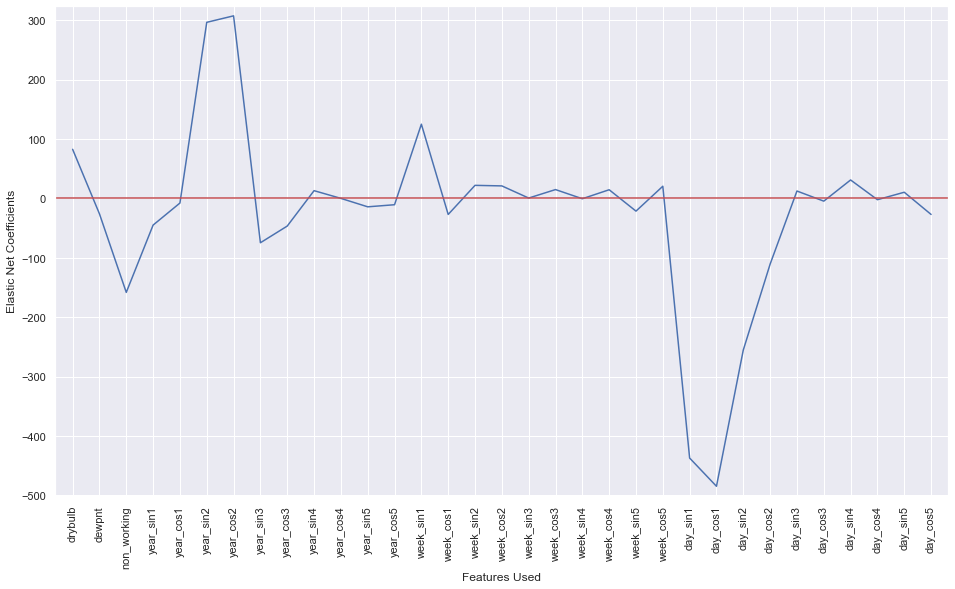

In [124]:
plt.figure(figsize=(16,9))
sns.lineplot(x=(range(len(X_train.columns))), y=elastic_net_opt.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.02)
plt.axhline(0, color='r')
plt.ylabel('Elastic Net Coefficients')
plt.xlabel('Features Used')

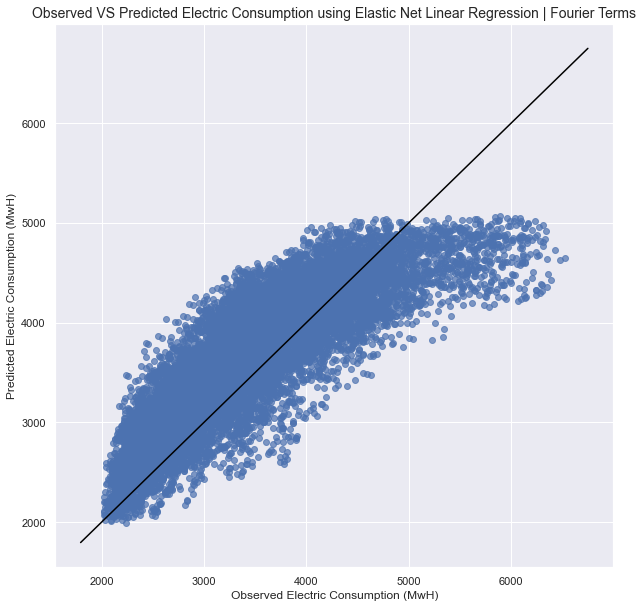

In [125]:
PredTrueReg(elastic_net_opt.predict(X_test), y_test, model_name='Elastic Net Linear Regression | Fourier Terms')

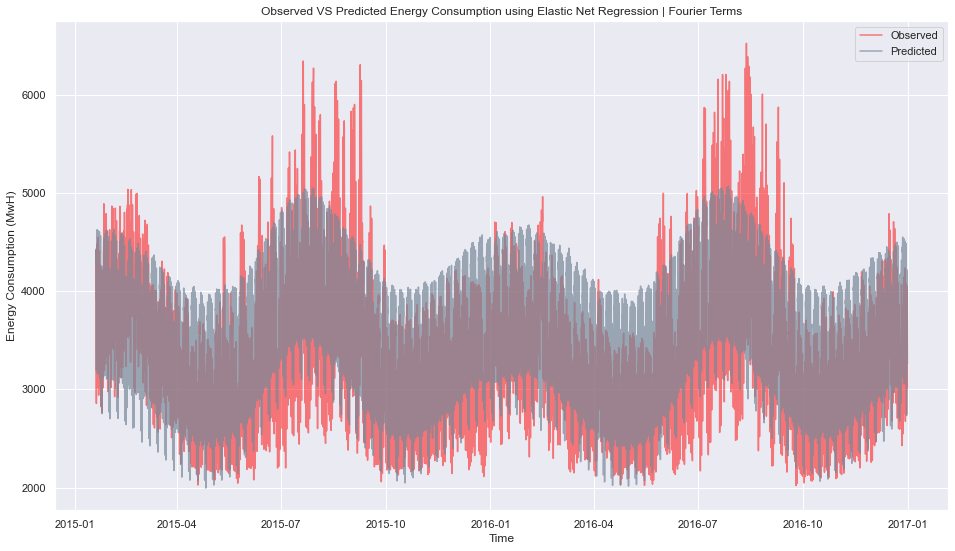

In [126]:
PlotPredictedTS(y_test, elastic_net_opt.predict(X_test), model_name='Elastic Net Regression | Fourier Terms')

## 7.2 Random Forest

In [127]:
estimators = list(np.linspace(10, 200, 10, endpoint=True, dtype=int))
features = ['auto', 'sqrt']
depth = [3,4,5,6,7,8]

random_grid = {'n_estimators': estimators, 'max_features': features, 'max_depth': depth}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8]}


In [128]:
rf = RandomForestRegressor()

tscv = TimeSeriesSplit(n_splits=5)

rf_random_fourier = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, cv=tscv, verbose=2, n_jobs=-1)

rf_random_fourier.fit(X_train, y_train)

rf_random_fourier.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 136, 'max_features': 'sqrt', 'max_depth': 8}

In [129]:
rf_fourier = RandomForestRegressor(n_estimators=rf_random_fourier.best_params_['n_estimators'], max_features=rf_random_fourier.best_params_['max_features'], max_depth=rf_random_fourier.best_params_['max_depth'])
rf_fourier.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=136)

In [130]:
error_metrics(rf_fourier.predict(X_train), y_train, model_name='Random Forest | Fourier Terms', test=False)
error_metrics(rf_fourier.predict(X_test), y_test, model_name='Random Forest | Fourier Terms', test=True)

Error metrics for Random Forest | Fourier Terms 

Root Mean Squared Error (RMSE): 276.875
Mean Absolute Error (MAE): 216.446
Mean Absolute Percentage Error (MAPE): 6.062 %
Variance Score (R2): 0.878
Error metrics for Random Forest | Fourier Terms 

Root Mean Squared Error (RMSE): 357.029
Mean Absolute Error (MAE): 309.783
Mean Absolute Percentage Error (MAPE): 9.784 %
Variance Score (R2): 0.788


In [131]:
error_metrics(elastic_net_opt.predict(X_train), y_train, model_name='Elastic Net | Fourier Terms', test=False)
error_metrics(elastic_net_opt.predict(X_test), y_test, model_name='Elastic Net | Fourier Terms', test=True)

Error metrics for Elastic Net | Fourier Terms 

Root Mean Squared Error (RMSE): 416.828
Mean Absolute Error (MAE): 312.454
Mean Absolute Percentage Error (MAPE): 8.497 %
Variance Score (R2): 0.724
Error metrics for Elastic Net | Fourier Terms 

Root Mean Squared Error (RMSE): 481.626
Mean Absolute Error (MAE): 400.384
Mean Absolute Percentage Error (MAPE): 12.057 %
Variance Score (R2): 0.613


Random Forest Feature Importance

<AxesSubplot:xlabel='importance', ylabel='feature'>

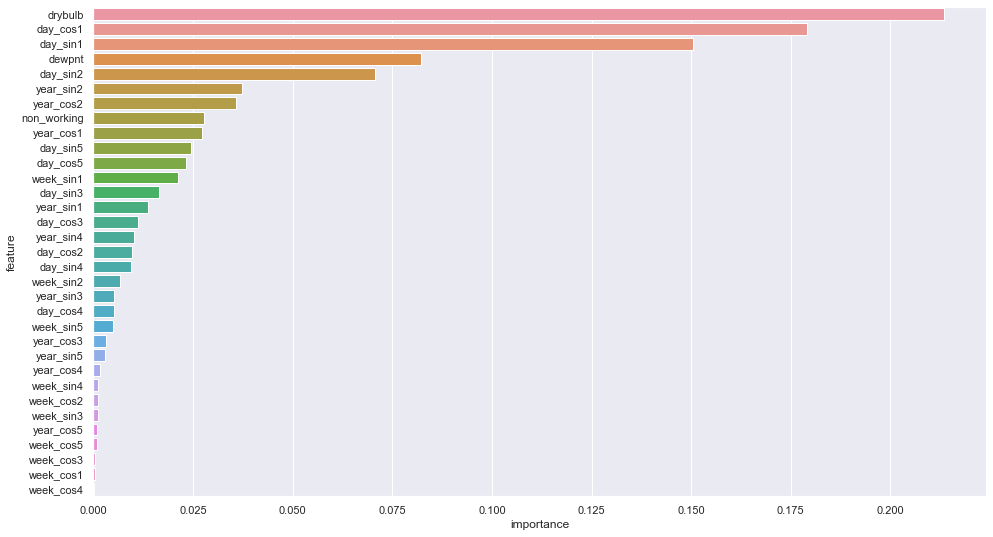

In [132]:
rf_features = {'importance': rf_fourier.feature_importances_, 'feature': X_train.columns}
rf_features = pd.DataFrame(rf_features)
rf_features = rf_features.sort_values(by='importance', ascending=False)
rf_features = rf_features.set_index('feature')

plt.figure(figsize=(16,9))
sns.barplot(data = rf_features, y=rf_features.index, x=rf_features['importance'])

<AxesSubplot:xlabel='importance', ylabel='feature'>

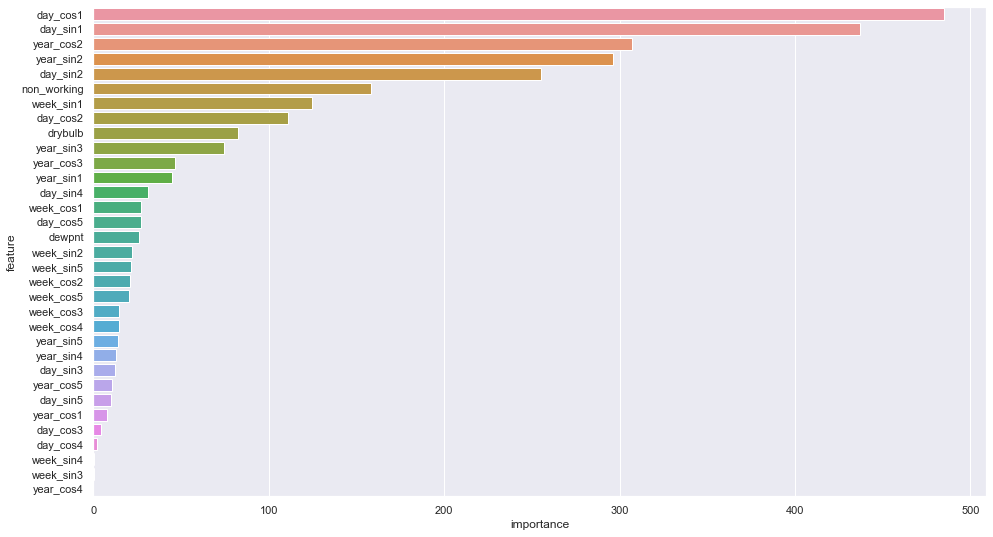

In [133]:
ElasticN_features = {'importance': np.abs(elastic_net_opt.coef_), 'feature': X_train.columns}
ElasticN_features = pd.DataFrame(ElasticN_features)
ElasticN_features = ElasticN_features.sort_values(by='importance', ascending=False)
ElasticN_features = ElasticN_features.set_index('feature')

plt.figure(figsize=(16,9))
sns.barplot(data = ElasticN_features, y=ElasticN_features.index, x=ElasticN_features['importance'])

## 7.3 XGBoost

In [134]:
import xgboost as xgb

In [135]:
RegressionXG = xgb.XGBRegressor(objective='reg:linear', colsample_bytree= 0.3, learning_rate=0.1, max_depth=3, alpha=5, n_estimators=100)
RegressionXG.fit(X_train, y_train)


[14:46:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, ...)

In [136]:
error_metrics(RegressionXG.predict(X_train), y_train, model_name='XGBoost | Fourier Terms', test=False)

Error metrics for XGBoost | Fourier Terms 

Root Mean Squared Error (RMSE): 230.615
Mean Absolute Error (MAE): 179.907
Mean Absolute Percentage Error (MAPE): 4.972 %
Variance Score (R2): 0.916


In [137]:
error_metrics(RegressionXG.predict(X_test), y_test, model_name='XGBoost | Fourier Terms', test=True)

Error metrics for XGBoost | Fourier Terms 

Root Mean Squared Error (RMSE): 314.614
Mean Absolute Error (MAE): 270.674
Mean Absolute Percentage Error (MAPE): 8.253 %
Variance Score (R2): 0.835


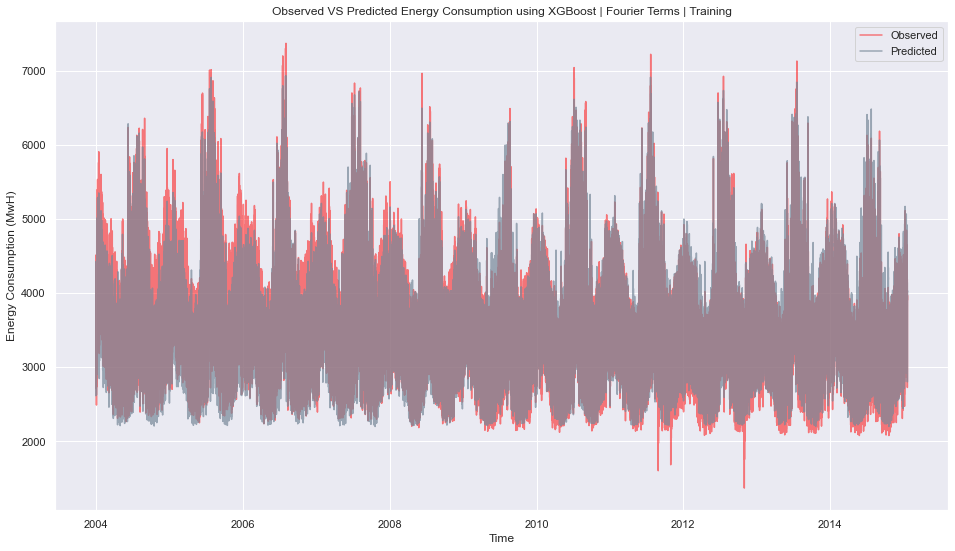

In [138]:
PlotPredictedTS(y_train, RegressionXG.predict(X_train), model_name='XGBoost | Fourier Terms | Training')

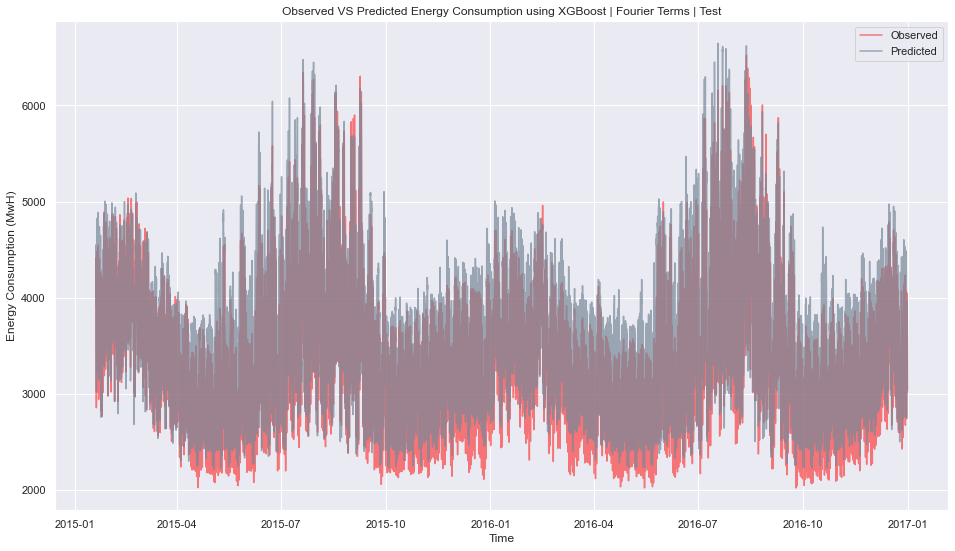

In [139]:
PlotPredictedTS(y_test, RegressionXG.predict(X_test), model_name='XGBoost | Fourier Terms | Test')

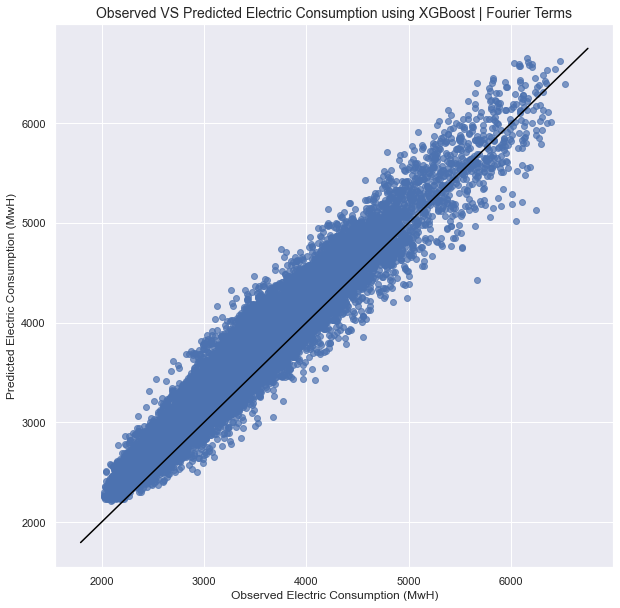

In [140]:
PredTrueReg(RegressionXG.predict(X_test), y_test, model_name='XGBoost | Fourier Terms')

Error Metrics for max daily XGBoost Forecast

In [141]:
predXG_train = pd.Series(RegressionXG.predict(X_train), index=X_train.index)
predXG_test = pd.Series(RegressionXG.predict(X_test), index= y_test.index)

error_metrics(predXG_train.resample('24h').max(), y_train.resample('24h').max(), model_name='XGBoost | Fourier Terms | MAX Daily', test=False)
error_metrics(predXG_test.resample('24h').max(), y_test.resample('24h').max(), model_name='XGBoost | Fourier Terms | MAX Daily', test=True)

Error metrics for XGBoost | Fourier Terms | MAX Daily 

Root Mean Squared Error (RMSE): 269.836
Mean Absolute Error (MAE): 214.762
Mean Absolute Percentage Error (MAPE): 4.919 %
Variance Score (R2): 0.844
Error metrics for XGBoost | Fourier Terms | MAX Daily 

Root Mean Squared Error (RMSE): 338.9
Mean Absolute Error (MAE): 290.88
Mean Absolute Percentage Error (MAPE): 7.328 %
Variance Score (R2): 0.778


In [142]:
temp = pd.Series(RegressionXG.predict(X_test), index=y_test.index)
temp.resample('d')

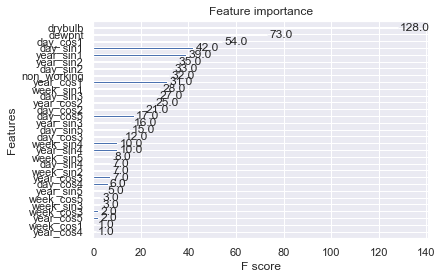

In [143]:
from matplotlib import rcParams

xgb.plot_importance(RegressionXG)
plt.rcParams['figure.figsize'] = [10, 4.5]

### 7.3.1 Tuned XGBoost

In [144]:
XGBoost_tuned = xgb.XGBRegressor()

param_tune_params = {
    'max_depth': list(range(3,11)),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': np.linspace(0.1, 1, 10),
    'colsample_bytree': np.linspace(0.1, 1, 10),
    'colsample_bylevel': np.linspace(0.1, 1, 10),
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': np.linspace(0, 1, 5),
    'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]
}



In [145]:
tscv = TimeSeriesSplit(n_splits=3)
RegressionXG_tuned = RandomizedSearchCV(XGBoost_tuned, param_distributions=param_tune_params, scoring='neg_mean_squared_error', n_iter=20, n_jobs=-1, cv=tscv, verbose=2)
RegressionXG_tuned.fit(X_train, y_train)
bestScore = RegressionXG_tuned.best_score_
bestParam = RegressionXG_tuned.best_params_
print(f'Best Score: {bestScore}')
print(f'Best Params: {bestParam}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Score: -42678.590593136694
Best Params: {'subsample': 0.9, 'n_estimators': 10, 'min_child_weight': 3.0, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.25, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4}


In [146]:
error_metrics(RegressionXG_tuned.predict(X_train), y_train, model_name='XGBoost Tuned | Fourier Terms', test=False)

Error metrics for XGBoost Tuned | Fourier Terms 

Root Mean Squared Error (RMSE): 222.853
Mean Absolute Error (MAE): 171.116
Mean Absolute Percentage Error (MAPE): 4.552 %
Variance Score (R2): 0.921


In [147]:
error_metrics(RegressionXG_tuned.predict(X_test), y_test, model_name='XGBoost Tuned | Fourier Terms', test=True)

Error metrics for XGBoost Tuned | Fourier Terms 

Root Mean Squared Error (RMSE): 238.876
Mean Absolute Error (MAE): 197.583
Mean Absolute Percentage Error (MAPE): 5.856 %
Variance Score (R2): 0.905


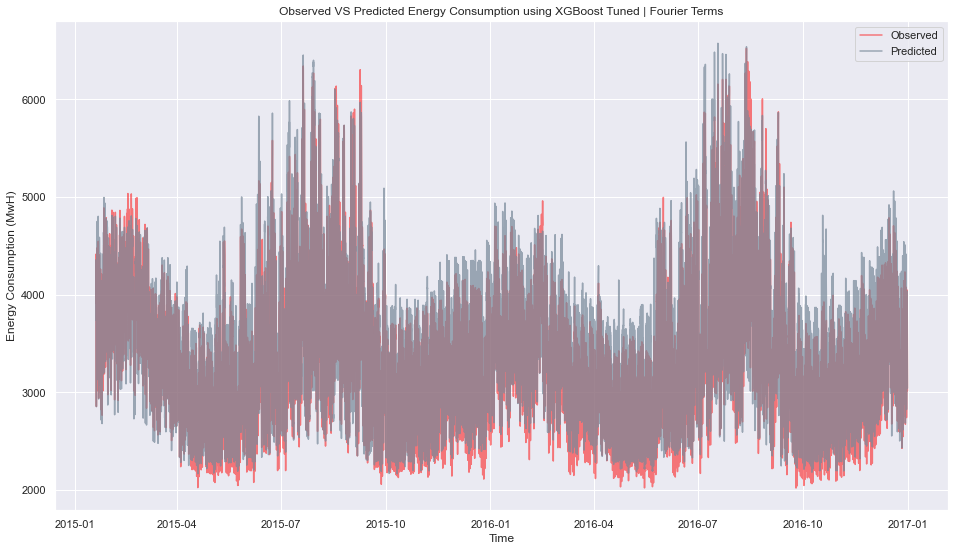

In [148]:
PlotPredictedTS(y_test, RegressionXG_tuned.predict(X_test), model_name='XGBoost Tuned | Fourier Terms')

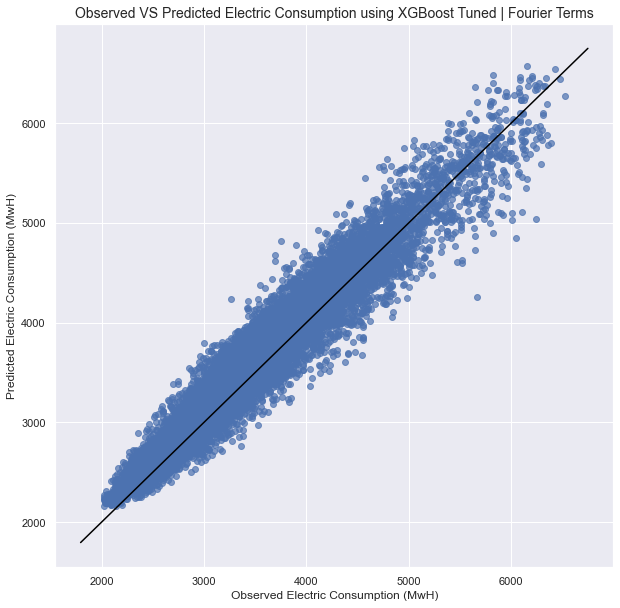

In [149]:
PredTrueReg(RegressionXG_tuned.predict(X_test), y_test, model_name='XGBoost Tuned | Fourier Terms')

## 7.4 XGBoost + FB Prophet Trend

<AxesSubplot:>

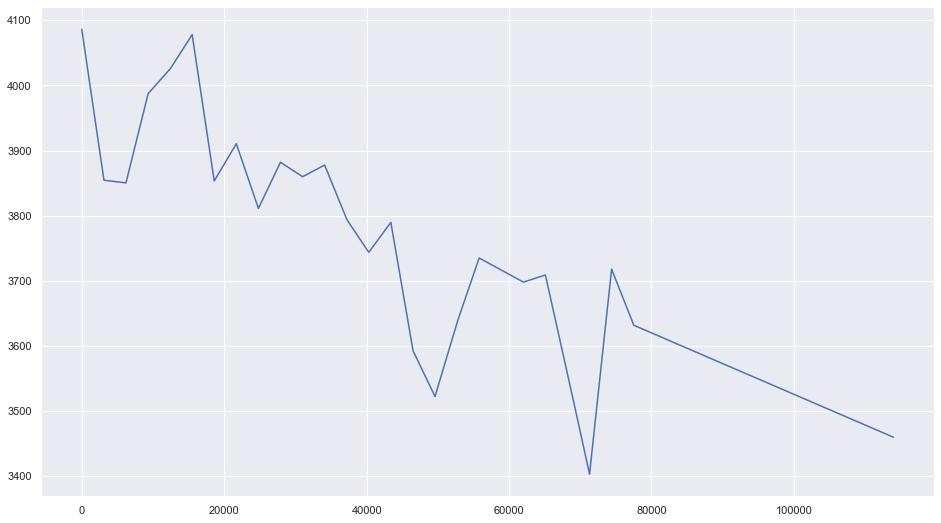

In [150]:
plt.figure(figsize=(16,9))
forecast.trend.plot()


In [151]:
XG_FB_Data = demandFourier.copy()
XG_FB_Data['demand'] = XG_FB_Data['demand'].to_numpy() - (forecast.trend).to_numpy()
XG_FB_Data['demand'].isna().sum()

0

<AxesSubplot:xlabel='ts'>

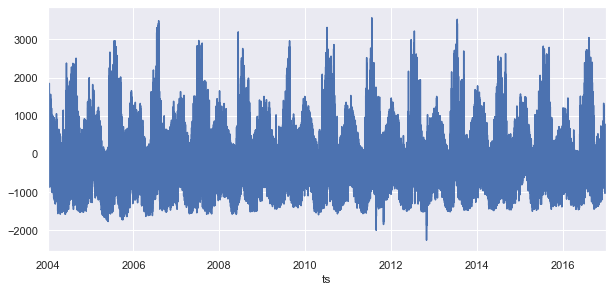

In [152]:
XG_FB_Data['demand'].plot()

In [153]:
transformCols = ['drybulb', 'dewpnt']
X_train, X_test, y_train, y_test = TrainTestSplit(XG_FB_Data, cols_to_transform=transformCols, scale=True, include_test_scale=False)
X_trainOG, X_testOG, y_trainOG, y_testOG = TrainTestSplit(demandFourier, cols_to_transform=transformCols, scale=True, include_test_scale=False)

In [154]:
XG_FB = xgb.XGBRegressor(objective='reg:linear', n_estimators=52, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.2, colsample_bytree=0.9, colsample_bylevel=1)

In [155]:
XG_FB.fit(X_train, y_train)

[14:48:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=52, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [156]:
XG_FB_pred = XG_FB.predict(X_test)
trend = (forecast.trend).to_numpy()
XG_FB_trend = XG_FB_pred + trend[-len(y_test):]

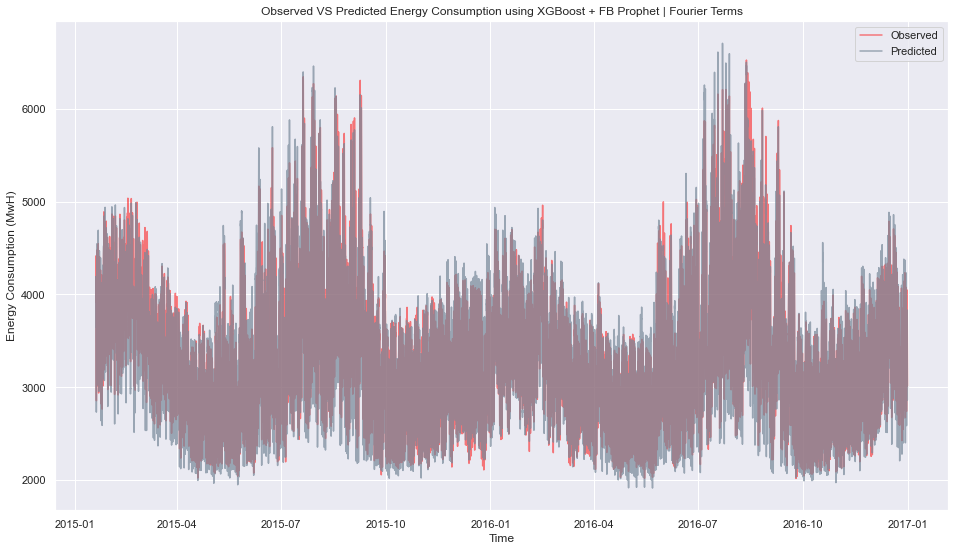

In [157]:
PlotPredictedTS(y_testOG, XG_FB_trend, model_name='XGBoost + FB Prophet | Fourier Terms')

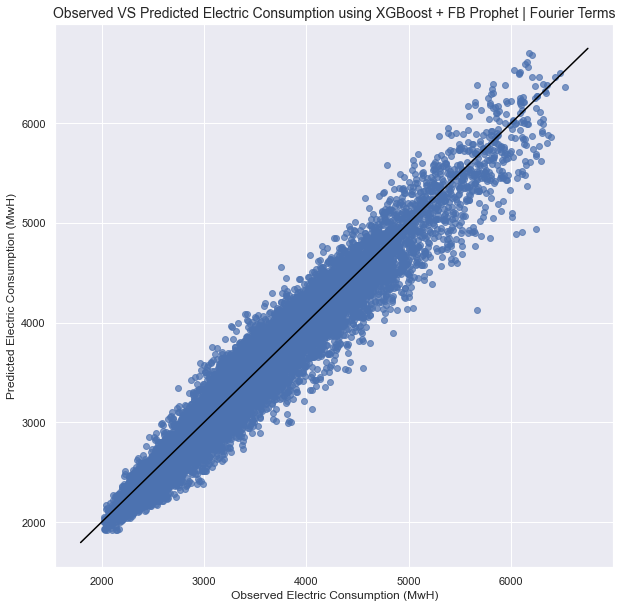

In [158]:
PredTrueReg(XG_FB_trend, y_testOG, model_name='XGBoost + FB Prophet | Fourier Terms')

In [159]:
# Training Error Metrics
XG_FB_pred_train = XG_FB.predict(X_train)
XG_FB_trend_train = XG_FB_pred_train + trend[:(len(trend) - len(y_testOG))]
error_metrics(XG_FB_trend_train, y_trainOG, model_name='XGBoost + FB Prophet | Fourier Terms', test=False)

Error metrics for XGBoost + FB Prophet | Fourier Terms 

Root Mean Squared Error (RMSE): 162.159
Mean Absolute Error (MAE): 118.715
Mean Absolute Percentage Error (MAPE): 3.266 %
Variance Score (R2): 0.958


In [160]:
error_metrics(XG_FB_trend, y_testOG, model_name='XGBoost + FB Prophet | Fourier Terms', test=True)

Error metrics for XGBoost + FB Prophet | Fourier Terms 

Root Mean Squared Error (RMSE): 194.759
Mean Absolute Error (MAE): 149.918
Mean Absolute Percentage Error (MAPE): 4.33 %
Variance Score (R2): 0.937


# 8. Conclusion

In [161]:
dict_error

{'model': ['sklearn linear Regression Model with Scaling',
  'sklearn linear Regression Model with Scaling',
  'Baseline Persistent Forecast (One Year Before)',
  'Baseline Persistent Forecast (One Hour Before)',
  'Baseline Persistent Forecast (One Week Before)',
  'Ridge Regression (Scaled)',
  'Ridge Regression (Scaled)',
  'Elastic Net with reduced feature space',
  'Elastic Net with reduced feature space',
  'Random Forest with Reduced Feature Space',
  'Random Forest with Reduced Feature Space',
  'Random Forest | Lagged',
  'Random Forest | Lagged',
  'Elastic Net | Lagged',
  'Elastic Net | Lagged',
  'SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week',
  'SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week',
  'FB Prophtet with auto seasonality | One Week Ahead',
  'FB Prophtet with auto seasonality | One Week Ahead',
  'Random Forest | Fourier Terms',
  'Random Forest | Fourier Terms',
  'Elastic Net | Fourier Terms',
  'Elastic Net | Fourier Terms',
  'XGBoost | Fourier Te

In [162]:
table = pd.DataFrame.from_dict(dict_error)
pivot = table.pivot_table(index='model', columns='train_test', aggfunc='min').sort_values(('MAPE', 'test'), ascending=True)
pivot = (pivot.sort_index(axis=1, level=1, ascending=False).sort_index(axis=1, level=[0], sort_remaining=False)).round(3)
pivot.style.highlight_min(['MAPE', 'MAE', 'RMSE'], axis=0).highlight_max(['R2'], axis=0).highlight_null(null_color='grey')

<Figure size 1152x2304 with 0 Axes>

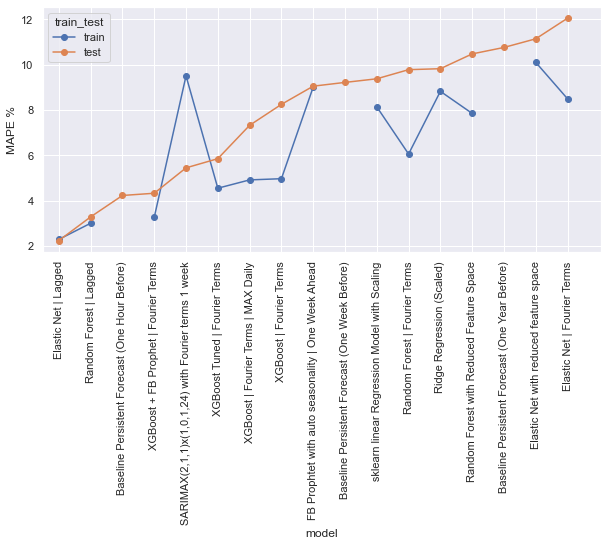

In [163]:
p = plt.figure(figsize=(16,32))
p = pivot['MAPE'].plot(style='o-')
p = plt.xticks(ticks = range(0,len(pivot)),labels = pivot.index.values,  rotation=90)
p = plt.xlim([-0.5,len(pivot)+0.05])
p = plt.ylabel('MAPE %')


In [164]:
import pickle
with open('dict_error.txt', 'wb') as myFile:
    pickle.dump(dict_error, myFile)
myFile.close()